# <font color= 'red'> PA005 - High Value Customer Identification

## Imput

## Business Challenge

- Select the most valuable customers to build the loyalty program called 'Insiders'.
- Data set with more product sales during the year. ( Nov/2015 - Dec/2017 )

## Output

1. Indication of people to be part of the program.
2. A report with the answers to following question:
    - Who are the eligible people for the Insiders Program?
    - How many people will be in the group?
    - Which are the main characteristics of these customers?
    - What is the percentage revenue contribution coming from Insiders?
    - What is the revenue expectation for the next few months?
    - Which are the conditions for the people to be eligible from the program?
    - Which are the conditions for the people to be removed from the program?
    - What is the guarantee that the Insiders Problem is better than the rest of the base?
    - What are the action the marketing time can do to enhance the revenue?

## Task - Process

1. Who are the eligible people for the Insiders Program?
    - What is be eligible? What are high value customers?
    - Income:
        - High averange ticket;
        - High LTV;
        - Low recently;
        - High basket size;
        - Low Churn probability;
        - High LTV probability;
        - High buy propensity;
        
        
   - Cost:  
        - Low return rate;
    
    
   - Buyer Experience:
        - High averange rate;
2. How many people will be in the group?
    - Total customers number;
    - % Insider Group;
    
    
3. Which are the main characteristics of these customers?
    - Customer characteristics:
        - Age;
        - Location;
        
    -  Consumption characteristics:
        - Clustering Attributtes;
        
4. What is the percentage revenue contribution coming from Insiders?
    - Total revenue of the year;
    - Renenue of the Insiders group;
        
        
5. What is the revenue expectation for the next few months? 
    - LTV of the Insider Group;
    - Cohort Analysis;
    
    
6. Which are the conditions for the people to be eligible from the program?
    - Define the periodicity ( 1 month, 3 months);
    - The people needs to be similary or seemed to other people in the group?
    
    
7. Which are the conditions for the people to be removed from the program?
    - Define the periodicity ( 1 month, 3 months);
    - The people needs to be similary or seemed to other people in the group?
    
    
8. What is the guarantee that the Insiders Problem is better than the rest of the base?
    - A/B Test;
    - Bayesian A/B Test;
    - Hyphotesis Test;


9. What are the action the marketing time can do to enhance the revenue?
    - Discount;
    - Purchase Preferences
    - Front
    - Company Visit;

# 0.1 Import

In [363]:
import  inflection
import  pandas      as pd
import  seaborn     as sns
import  numpy       as np
import  umap.umap_  as umap

import  matplotlib.pyplot  as plt


from  sklearn  import  cluster       as c
from  sklearn  import  metrics       as m
from  sklearn  import  mixture       as mx
from  sklearn  import  ensemble      as en
from  sklearn  import  decomposition as dd
from  sklearn  import  preprocessing as pp
from  sklearn  import  manifold      as mn
from  plotly   import  express       as px

from  scipy.cluster import hierarchy as hc

from  IPython.core.display    import HTML
from  pandas_profiling        import ProfileReport
from  yellowbrick.cluster     import KElbowVisualizer, SilhouetteVisualizer



# 0.2 Helper Functions

In [2]:
def jupyter_settings(): 
    %matplotlib inline 
    #%matplotlib notebook
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
     
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option ('display.expand_frame_repr', False)
    
    sns.set()

%matplotlib inline 
%matplotlib notebook

plt.style.use('bmh')
plt.rcParams['figure.figsize'] = [25, 12]
plt.rcParams['font.size'] = 24


display( HTML( '<style>.container { width:100% !important; }</style>') )
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option ('display.expand_frame_repr', False)

sns.set()

jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# <font color= 'red'> 1.0 Data Description

## 1.1 Loading Dataset

In [5]:
df_raw = pd.read_csv( '/Users/adriele/Documents/repos/pa005/data/ecommerce.csv', encoding='cp1252' )



In [6]:
# dropping extra column
df_raw = df_raw.drop( columns= ['Unnamed: 8'], axis=1 )

## 1.2 Rename Columns

In [7]:
df1 = df_raw.copy()
df_raw.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [8]:
# Renaming Cols
cols_old = [ 'InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

snakecase = lambda x: inflection.underscore (x)

cols_new = list (map (snakecase , cols_old))

# rename
df1.columns = cols_new

## 1.3 Data Dimensions

In [9]:
print( 'Number of Cols {}'.format( df1.shape[1] ) )
print( 'Number of Rows {}'.format( df1.shape[0] ) )

Number of Cols 8
Number of Rows 541909


In [10]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## 1.4 Check NA

In [11]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Replace NA

In [12]:
df_missing = df1.loc[ df1[ 'customer_id' ].isna(), :]
df_not_missing = df1.loc[ ~df1['customer_id' ].isna(), :]

In [13]:
# Create reference
df_backup = pd.DataFrame( df_missing['invoice_no'].drop_duplicates() )
df_backup[ 'customer_id' ] = np.arange( 19000, 19000+len( df_backup ), 1)

# Merge original with reference df
df1 = pd.merge( df1, df_backup, on='invoice_no', how='left' )

# Coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first( df1['customer_id_y'])

# drop extra column
df1 = df1.drop( columns=['customer_id_x', 'customer_id_y'], axis=1 )
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,United Kingdom,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,United Kingdom,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,United Kingdom,17850.0


In [14]:
missing_invoice = df_missing['invoice_no'].drop_duplicates().tolist()
missing_invoice[0:10]

['536414',
 '536544',
 '536545',
 '536546',
 '536547',
 '536549',
 '536550',
 '536552',
 '536553',
 '536554']

In [15]:
df_not_missing.loc[ df_not_missing[ 'invoice_no' ].isin( missing_invoice ), :].head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country


In [16]:
# removing Na
df1 = df1.dropna( subset=[ 'description', 'customer_id'] )
print( 'Removed Data: {:.2f}%'.format( 1-( df1.shape[0] / df_raw.shape[0] ) ) )

Removed Data: 0.00%


In [17]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
country         0
customer_id     0
dtype: int64

## 1.6 Data Types

In [18]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
country          object
customer_id     float64
dtype: object

In [19]:
# Invoice Date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y')

# Customer Id
df1['customer_id'] = df1['customer_id'].astype( int)

In [20]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 1.7 Descriptive Startistcs

In [21]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=[ 'int64', 'float64', 'datetime64[ns]'] )

### 1.7.1 Numerical Attributes

- Negative quantity can be returns;
- Unitary price equal 0 can be promotions;

In [22]:
# Central Tendency - mean, Median
ct1 = pd.DataFrame (num_attributes.apply (np.mean) ).T
ct2 = pd.DataFrame (num_attributes.apply (np.median) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame (num_attributes.apply (np.std) ).T
d2 = pd.DataFrame (num_attributes.apply (min)).T
d3 = pd.DataFrame (num_attributes.apply (max)).T
d4 = pd.DataFrame (num_attributes.apply (lambda x: x.max () -x.min ()) ).T
d5 = pd.DataFrame (num_attributes.apply (lambda x: x.skew () ) ).T
d6 = pd.DataFrame (num_attributes.apply (lambda x: x.kurtosis ()) ).T

# Concatane
m =pd.concat ([ d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.603129,3.00,218.007397,-0.281253,120252.449063
1,unit_price,-11062.06,38970.0,50032.06,4.623519,2.08,96.889538,186.257919,58848.017575
2,customer_id,12346.00,22709.0,10363.00,16678.153600,16241.00,2907.570262,0.493600,-0.792496


### 1.7.2 Attributes Category

In [23]:
cat_attributes.apply (lambda x: x.unique().shape [0])


invoice_no     24446
stock_code      3958
description     4223
country           38
dtype: int64

#### Invoice No

In [24]:
# Invoice No
df_letter_invoices = df1.loc[df1[ 'invoice_no' ].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), :]

print( 'Total number of invoices: {}'.format( len( df_letter_invoices) ) )
print( 'Total number of negative invoices: {}'.format( len( df_letter_invoices[ df_letter_invoices[ 'quantity' ] < 0] ) ) )

Total number of invoices: 9291
Total number of negative invoices: 9288


#### Stock Code

In [25]:
# Stock code - check characters
df1.loc[df1[ 'stock_code' ].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique()



array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

#### Descripition


In [26]:


df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


#### Country

In [27]:
df1['country'].value_counts( normalize=True ).head()

United Kingdom    0.914089
Germany           0.017569
France            0.015833
EIRE              0.015165
Spain             0.004687
Name: country, dtype: float64

In [28]:
c = df1[['customer_id', 'country']].drop_duplicates().groupby( 'country' ).count(
).reset_index().sort_values( 'customer_id', ascending=False )

c.head()

,country,customer_id
36,United Kingdom,6133
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31


# <font color= 'red'> 2.0 Feature Filtering

In [232]:
df2 = df1.copy()

In [233]:
# Numerical Attributes
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# Categorical Attributes
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'] ) ]

#Descrption
df2 = df2.drop( columns='description', axis=1 )

# Description
df2= df2[~df2['country'].isin( ['European Comunity', 'Unspecified'] ) ]

# Bad Users
df2 = df2[~df2['customer_id'].isin( [16446] )]
# Quantity
df2_returns = df2.loc[ df1[ 'quantity' ] <0, : ]
df2_purchases = df2.loc[ df1[ 'quantity' ] >=0, : ]

# <font color= 'red'> 3.0 Feature Engineering

In [180]:
df3 = df2.copy()

## 3.1 Feature Creation

In [181]:
# Data reference
df_ref = df3.drop(['invoice_no', 'stock_code','quantity', 
          'invoice_date', 'unit_price', 'country'], axis=1).drop_duplicates( ignore_index=True )
df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


### 3.1.1 Gross Revenue

In [182]:
# Gross Revenue = quantity * price
df2_purchases.loc[:,'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']

# Monetary
df_monetary = df2_purchases.loc[:, [ 'customer_id', 'gross_revenue' ]].groupby( 'customer_id' ).sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )
df_ref.isna().sum()

/var/folders/pc/6sglrsq96ws5kp74fjj4j02h0000gn/T/ipykernel_33779/1692327438.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_purchases.loc[:,'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']


customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2 Recency - Last Day Purchase

In [183]:
# Recency - Last day purchase

df_recency = df2_purchases.loc[:, ['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df2['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.3 Purchase Quantity 

In [184]:
# Quantity of products

df_freq = (df2_purchases.loc[:, ['customer_id', 'invoice_no']].drop_duplicates().groupby( 'customer_id' ).count().reset_index().rename( columns={ 'invoice_no': 'qtde_invoices'}) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
dtype: int64

### 3.1.4 Quantity of Itens Purchased

In [185]:
df_freq = (df2_purchases.loc[:, ['customer_id', 'quantity']].drop_duplicates().groupby( 'customer_id').sum
           ().reset_index().rename( columns={ 'quantity': 'qtde_itens'} ) )

df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_itens       91
dtype: int64

### 3.1.5 Quantity of Products Purchased

In [186]:
df_freq = (df2_purchases.loc[:, ['customer_id', 'stock_code']].drop_duplicates().groupby( 'customer_id').count
           ().reset_index().rename( columns={ 'stock_code': 'qtde_products'} ) )

df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_itens       91
qtde_products    91
dtype: int64

### 3.1.6 Averange Ticket Value  **

In [187]:
df_avg_ticket = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].drop_duplicates().groupby( 'customer_id').mean().reset_index().rename( columns={ 'gross_revenue': 'avg_ticket'} )

df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_itens       91
qtde_products    91
avg_ticket       91
dtype: int64

### 3.1.7 Averange Recency Day

In [188]:
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values( ['customer_id', 'invoice_date'])
df_aux['next_customer_id'] = df_aux['customer_id'].shift()
df_aux['previous_date'] = df_aux['invoice_date'].shift()

df_aux['avg_recency_days'] = df_aux.apply( lambda x: ( x['invoice_date'] - x['previous_date']
                                                     ).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1 )

df_aux = df_aux.drop( ['invoice_date', 'next_customer_id', 'previous_date'], axis=1).dropna()

# Average recency
df_avg_recency_days = df_aux.groupby( 'customer_id' ).mean().reset_index()

# Merge
df_ref = pd.merge( df_ref, df_avg_recency_days, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_itens            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
dtype: int64

### 3.1.8 Frequency Purchase

In [189]:
df2_max = df2[['customer_id', 'invoice_date']].drop_duplicates().groupby( 'customer_id' ).max()
df2_min = df2[['customer_id', 'invoice_date']].drop_duplicates().groupby( 'customer_id' ).min()
df2_purchase = df2[['customer_id']].drop_duplicates().groupby( 'customer_id' ).count()


In [190]:
df_aux = ( df2[[ 'customer_id', 'invoice_date', 'invoice_no']].drop_duplicates()
                                                              .groupby( 'customer_id' )
                                                              .agg( max_ = ( 'invoice_date', 'max' ),
                                                                    min_ = ( 'invoice_date', 'min' ),
                                                                    days_ = ( 'invoice_date', lambda x: ( x.max()  - x.min() ).days ),
                                                                    buy_ = ( 'invoice_no', 'count') ) ).reset_index()

# Frequency
df_aux['frequency'] = df_aux[[ 'buy_', 'days_' ]].apply( lambda x: x[ 'buy_' ] / x['days_'] if x['days_'] != 0 else 0, axis=1 )


# Merge
df_ref = pd.merge( df_ref, df_aux[[ 'customer_id', 'frequency' ]], on='customer_id', how='left')
df_ref.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_itens,qtde_products,avg_ticket,avg_recency_days,frequency
0,17850,5391.21,372.0,34.0,35.0,21.0,27.223103,35.500000,0.492958
1,13047,3232.59,56.0,9.0,131.0,105.0,22.883617,27.250000,0.048930
2,12583,6705.38,2.0,15.0,1568.0,114.0,35.595256,23.187500,0.045822
3,13748,948.25,95.0,5.0,169.0,24.0,32.147500,92.666667,0.017986
4,15100,876.00,333.0,3.0,48.0,1.0,262.800000,8.600000,0.139535


In [191]:
df_aux.sort_values( 'frequency', ascending=False ).head()

,customer_id,max_,min_,days_,buy_,frequency
4246,18139,2017-11-20,2017-11-19,1,6,6.0
1991,15060,2017-11-29,2017-11-28,1,4,4.0
3061,16498,2017-06-29,2017-06-28,1,3,3.0
3925,17693,2017-07-24,2017-07-23,1,3,3.0
2475,15700,2017-06-18,2017-06-17,1,3,3.0


### 3.1.9 Number of Returns

In [192]:
df_returns = df2_returns[[ 'customer_id', 'quantity' ]].groupby( 'customer_id' ).sum(
                     ).reset_index().rename( columns={ 'quantity': 'qtde_returns' } )

df_returns[ 'qtde_returns' ] = df_returns[ 'qtde_returns' ] * -1

df_ref = pd.merge( df_ref, df_returns, how='left', on='customer_id' )
df_ref.loc[ df_ref[ 'qtde_returns' ].isna(), 'qtde_returns' ] = 0


df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_itens            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency              0
qtde_returns           0
dtype: int64

### 3.1.10 Basket Size - The itens quantity by basket.

- Invoice No = Purchase
- Stock code = Products
- Quantity = Itens

In [193]:
df_aux = ( df2_purchases.loc[:, [ 'customer_id', 'invoice_no', 'quantity']].groupby( 'customer_id' )
                                                                            .agg( n_purchase = ( 'invoice_no', 'nunique'),
                                                                                  n_products = ( 'quantity', 'sum') )
                                                                            .reset_index() ) 

# Calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# Merge 
df_ref = pd.merge( df_ref, df_aux[['customer_id','avg_basket_size']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_itens            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency              0
qtde_returns           0
avg_basket_size       91
dtype: int64

### 3.1.11 Unique Basket Size - The quantity of distinct products by purchase.

In [194]:
df_aux = ( df2_purchases.loc[:, [ 'customer_id', 'invoice_no', 'stock_code']].groupby( 'customer_id' )
                                                                            .agg( n_purchase = ( 'invoice_no', 'nunique'),
                                                                                  n_products = ( 'stock_code', 'count') )
                                                                            .reset_index() ) 

# Calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# Merge 
df_ref = pd.merge( df_ref, df_aux[['customer_id','avg_unique_basket_size']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
qtde_invoices               91
qtde_itens                  91
qtde_products               91
avg_ticket                  91
avg_recency_days          2816
frequency                    0
qtde_returns                 0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

# <font color= 'red'> 4.0 Exploratory Data Analysis

In [242]:
df4 = df_ref.dropna()
df4.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qtde_invoices             0
qtde_itens                0
qtde_products             0
avg_ticket                0
avg_recency_days          0
frequency                 0
qtde_returns              0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

## 4.1 Univariate Analysis

In [169]:
profile = ProfileReport( df4 )
profile.to_file( 'output.html' )

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### 4.1.1 Gross Revenue

In [176]:
df4.sort_values( 'gross_revenue', ascending=False).head(10)

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_itens,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size_x,avg_unique_basket_size_y
1017,14646,279138.02,1.0,72.0,15837.0,699.0,180.381253,7.844444,0.206799,288.0,2733.944444,28.611111,28.611111
492,18102,259657.30,0.0,60.0,12872.0,150.0,528.824622,14.680000,0.163488,0.0,1068.733333,7.183333,7.183333
433,17450,194550.79,8.0,46.0,38639.0,124.0,753.761139,12.821429,0.136490,952.0,1521.586957,7.326087,7.326087
3339,16446,168472.50,0.0,2.0,80996.0,3.0,56157.500000,205.000000,0.014634,80995.0,40498.500000,1.500000,1.500000
66,14911,140450.72,1.0,199.0,4247.0,1786.0,56.312667,2.601399,0.653226,3332.0,403.331658,28.507538,28.507538
1150,12415,124564.53,24.0,20.0,9932.0,443.0,224.358130,20.866667,0.076677,427.0,3868.650000,35.650000,35.650000
190,14156,117379.63,9.0,55.0,9208.0,714.0,153.380344,7.260000,0.179063,859.0,1052.454545,25.454545,25.454545
15,17511,91062.38,2.0,31.0,4375.0,453.0,110.195856,11.593750,0.121294,1535.0,2082.225806,31.064516,31.064516
12,16029,72882.09,38.0,62.0,10827.0,43.0,403.520633,9.054054,0.197015,8004.0,648.500000,3.887097,3.887097
955,16684,66653.56,4.0,28.0,8377.0,119.0,278.148333,22.125000,0.084746,864.0,1794.821429,9.892857,9.892857


In [243]:
df3[df3['customer_id'] == 14646].head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
37952,539491,21981,12,2016-12-18,0.29,Netherlands,14646
37953,539491,21986,12,2016-12-18,0.29,Netherlands,14646
37954,539491,22720,2,2016-12-18,4.95,Netherlands,14646
37955,539491,21931,1,2016-12-18,1.95,Netherlands,14646
37956,539491,22613,2,2016-12-18,0.85,Netherlands,14646


### 4.1.2 Items Quantity

In [254]:
df4[df4['qtde_itens'] == 196844].head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_itens,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size


### 4.1.3 Products Quantity

In [252]:
df3[df3['customer_id'] == 17841].head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
1441,C536543,22632,-1,2016-11-29,2.10,United Kingdom,17841
1442,C536543,22355,-2,2016-11-29,0.85,United Kingdom,17841
2037,536557,21495,25,2016-11-29,0.42,United Kingdom,17841
2038,536557,46000R,2,2016-11-29,1.45,United Kingdom,17841
2039,536557,46000S,1,2016-11-29,1.45,United Kingdom,17841


### 4.1.4 Avg Ticket 

In [253]:
df3[df3['customer_id'] == 16446].head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
194354,553573,22980,1,2017-05-16,1.65,United Kingdom,16446
194355,553573,22982,1,2017-05-16,1.25,United Kingdom,16446
540421,581483,23843,80995,2017-12-07,2.08,United Kingdom,16446
540422,C581484,23843,-80995,2017-12-07,2.08,United Kingdom,16446


### 4.1.5 Frequency

In [259]:
df4[df4['frequency'] == 17].head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_itens,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size


### 4.1.6 Avg Basket Size

In [260]:
df4[df4['avg_basket_size'] == 40498.5].head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_itens,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
3339,16446,168472.5,0.0,2.0,80996.0,3.0,56157.5,205.0,0.014634,80995.0,40498.5,1.5


## 4.2 Bivariate Analysis

In [249]:
cols = ['customer_id']
df42 = df4.drop( cols, axis=1 )

<Figure size 1800x864 with 0 Axes>

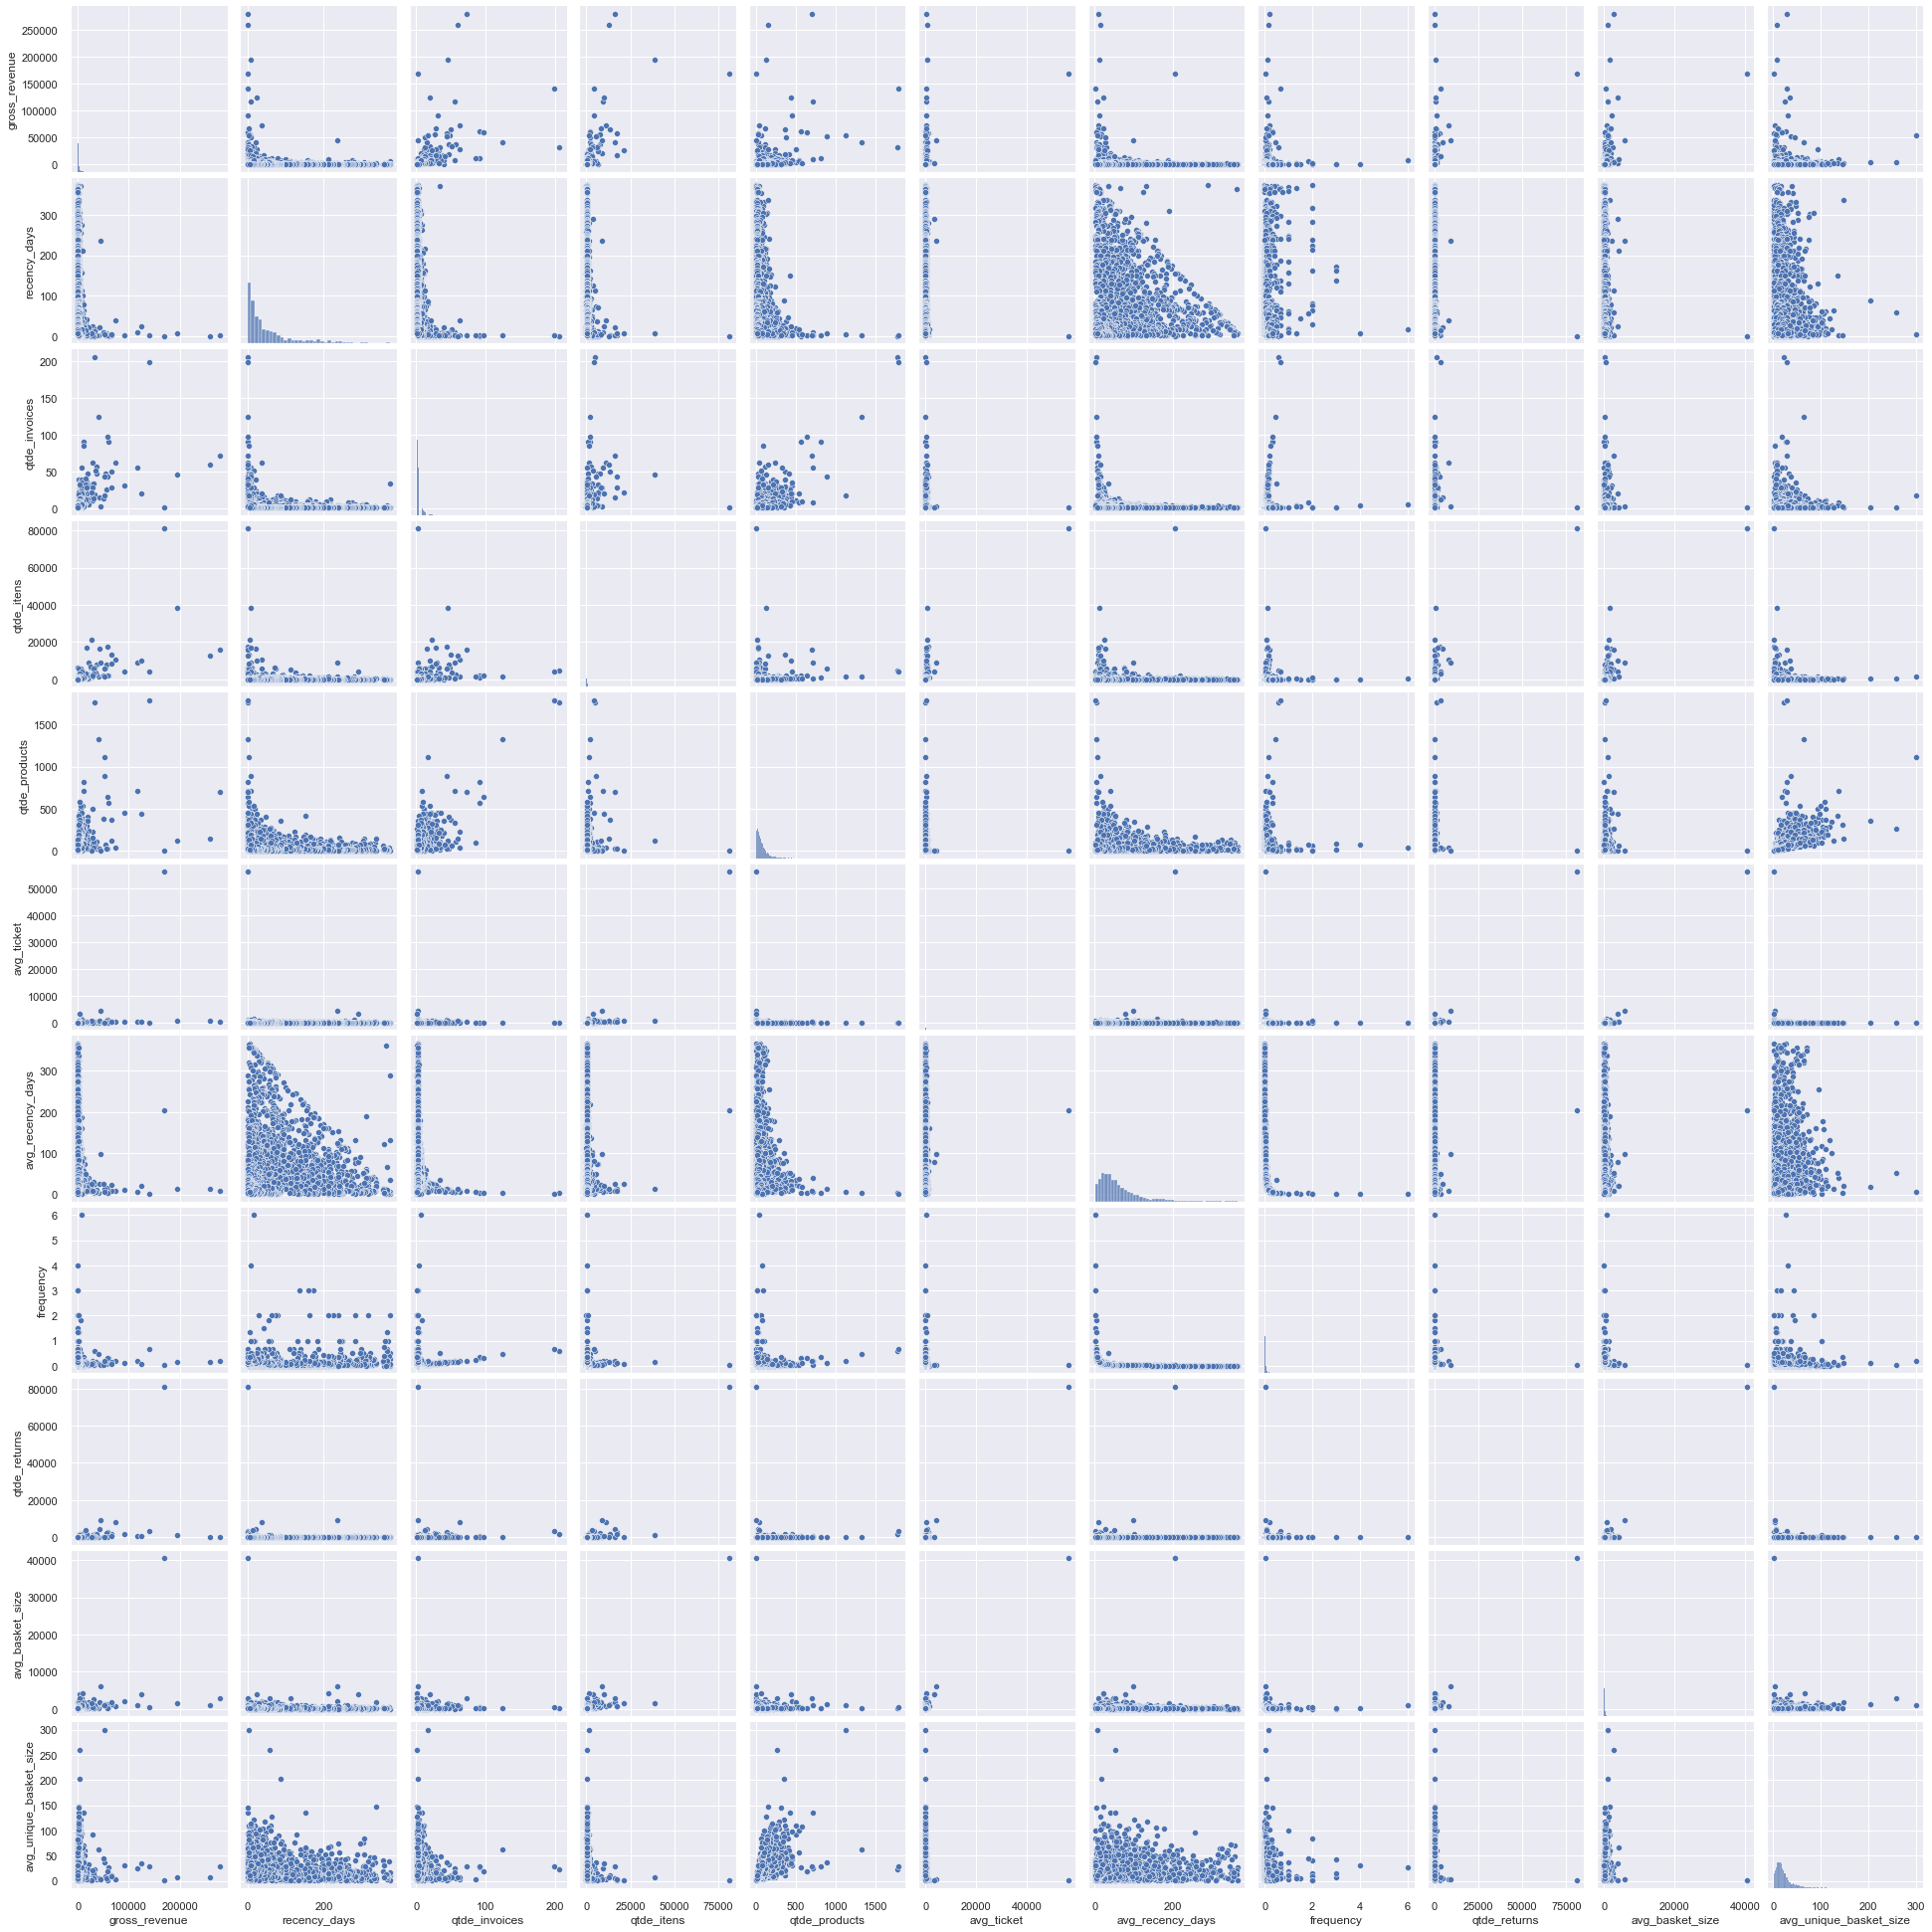

In [250]:
plt.figure( figsize=(25, 12) )
sns.pairplot( df42)

In [245]:
df4.columns

Index(['customer_id', 'gross_revenue', 'recency_days', 'qtde_invoices',
       'qtde_itens', 'qtde_products', 'avg_ticket', 'avg_recency_days',
       'frequency', 'qtde_returns', 'avg_basket_size',
       'avg_unique_basket_size'],
      dtype='object')

## 4.3 Space Study

In [196]:
df43 = df4.drop( columns='customer_id', axis=1 ).copy()

In [198]:
mm = pp.MinMaxScaler()

df43[ 'gross_revenue' ]    = mm.fit_transform( df43[[ 'gross_revenue' ]] )
df43[ 'recency_days' ]     = mm.fit_transform( df43[[ 'recency_days' ]] )
df43[ 'qtde_invoices' ]    = mm.fit_transform( df43[[ 'qtde_invoices' ]] )
df43[ 'qtde_itens' ]       = mm.fit_transform( df43[[ 'qtde_itens' ]] )
df43[ 'qtde_products' ]    = mm.fit_transform( df43[[ 'qtde_products' ]] )
df43[ 'avg_ticket' ]       = mm.fit_transform( df43[[ 'avg_ticket' ]] )
df43[ 'avg_recency_days' ] = mm.fit_transform( df43[[ 'avg_recency_days' ]] )
df43[ 'frequency' ]        = mm.fit_transform( df43[[ 'frequency' ]] )
df43[ 'qtde_returns' ]     = mm.fit_transform( df43[[ 'qtde_returns' ]] )
df43[ 'avg_basket_size' ]  = mm.fit_transform( df43[[ 'avg_basket_size' ]] )

df43[ 'avg_unique_basket_size' ] = mm.fit_transform( df43[[ 'avg_unique_basket_size' ]] )

x = df43.copy()

In [205]:
x.head()

,gross_revenue,recency_days,qtde_invoices,qtde_itens,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,0.019292,0.997319,0.160976,0.000420,0.011204,0.000444,0.094521,0.081323,0.000494,0.001234,0.025896
1,0.011559,0.150134,0.039024,0.001605,0.058263,0.000367,0.071918,0.007251,0.000432,0.003789,0.060260
2,0.024000,0.005362,0.068293,0.019347,0.063305,0.000593,0.060788,0.006732,0.000617,0.008252,0.048431
3,0.003375,0.254692,0.019512,0.002074,0.012885,0.000532,0.251142,0.002089,0.000000,0.002143,0.015400
4,0.003116,0.892761,0.009756,0.000580,0.000000,0.004639,0.020822,0.022365,0.000272,0.000634,0.000000


### 4.3.1 PCA

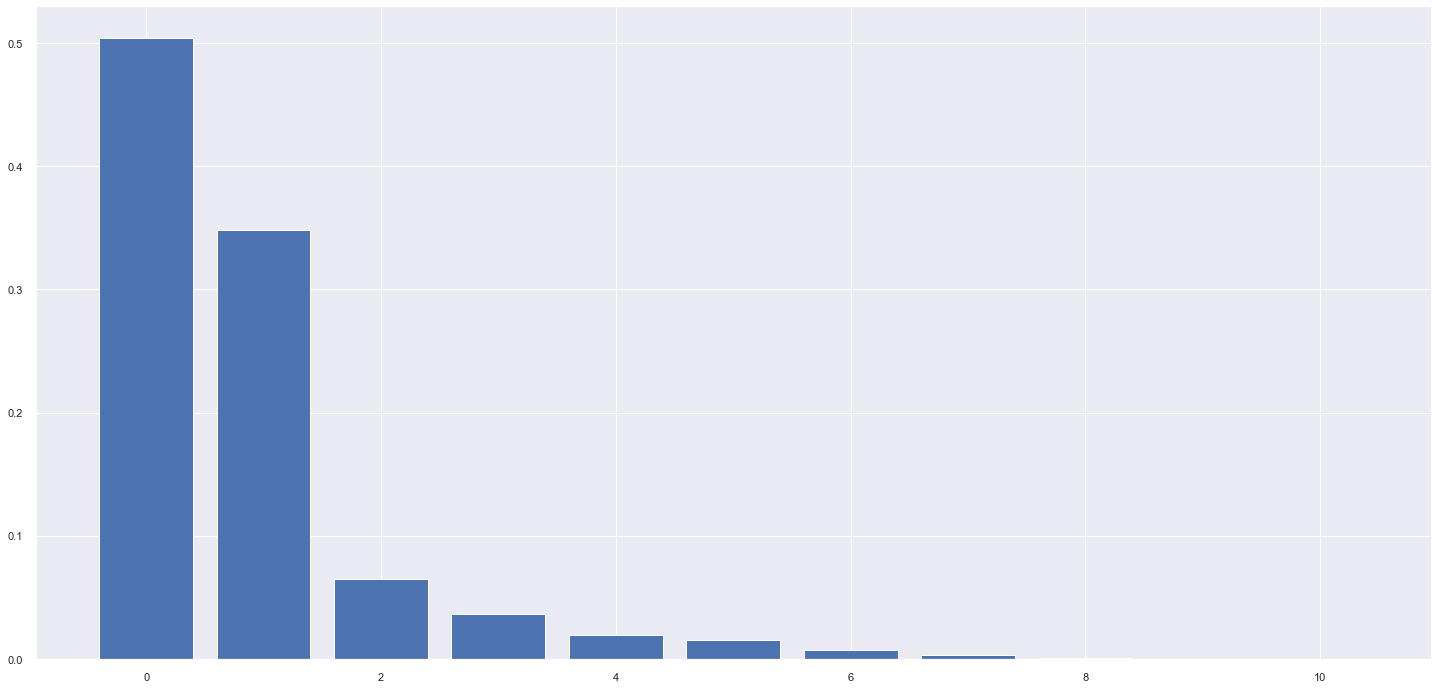

In [210]:
pca = dd.PCA( n_components =  x.shape[1] )

principal_components = pca.fit_transform( x )

# Plot Explaneid Variable
features = range( pca.n_components_ )

plt.bar( features, pca.explained_variance_ratio_)

# PCA Conponent
df_pca = pd.DataFrame( principal_components )

In [211]:
df_pca.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.824845,-0.008374,0.044304,0.132856,-0.054861,0.047447,0.003564,0.098211,-0.013484,0.001308,-0.002297
1,-0.010792,-0.112871,-0.004207,0.008778,-0.010714,-0.008965,0.004129,-0.000932,-0.002231,-0.001033,-0.000076
2,-0.154250,-0.142586,-0.016242,0.035281,-0.006719,-0.005882,0.002462,0.011592,0.007150,0.002304,-0.000320
3,0.077576,0.080526,-0.051430,0.021000,-0.011671,-0.007471,0.001906,0.000047,-0.000627,-0.000886,-0.000197
4,0.737369,-0.077013,-0.026571,0.034557,-0.013172,-0.018441,0.004566,-0.004190,-0.001544,-0.003621,-0.003137


<AxesSubplot:xlabel='0', ylabel='1'>

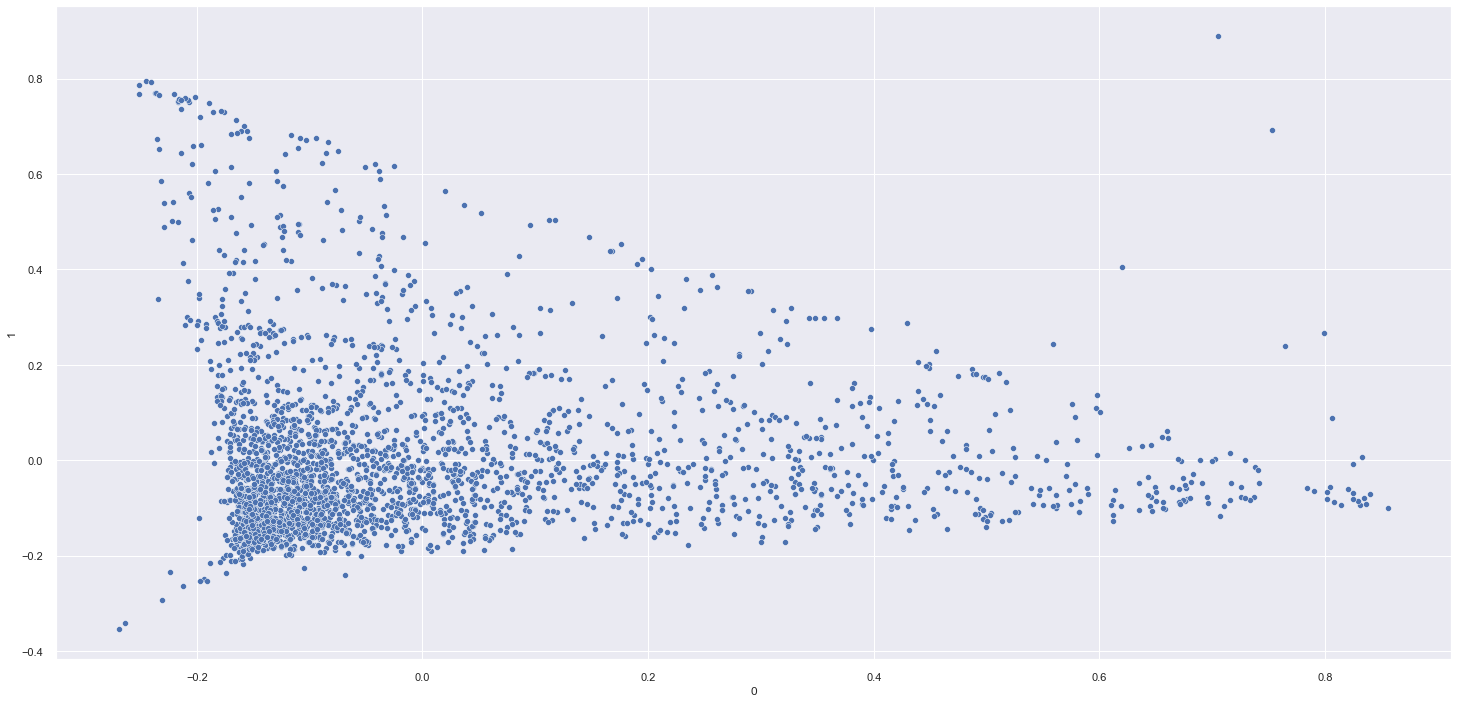

In [213]:
sns.scatterplot( x=0, y=1, data=df_pca )

### 4.3.2 UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

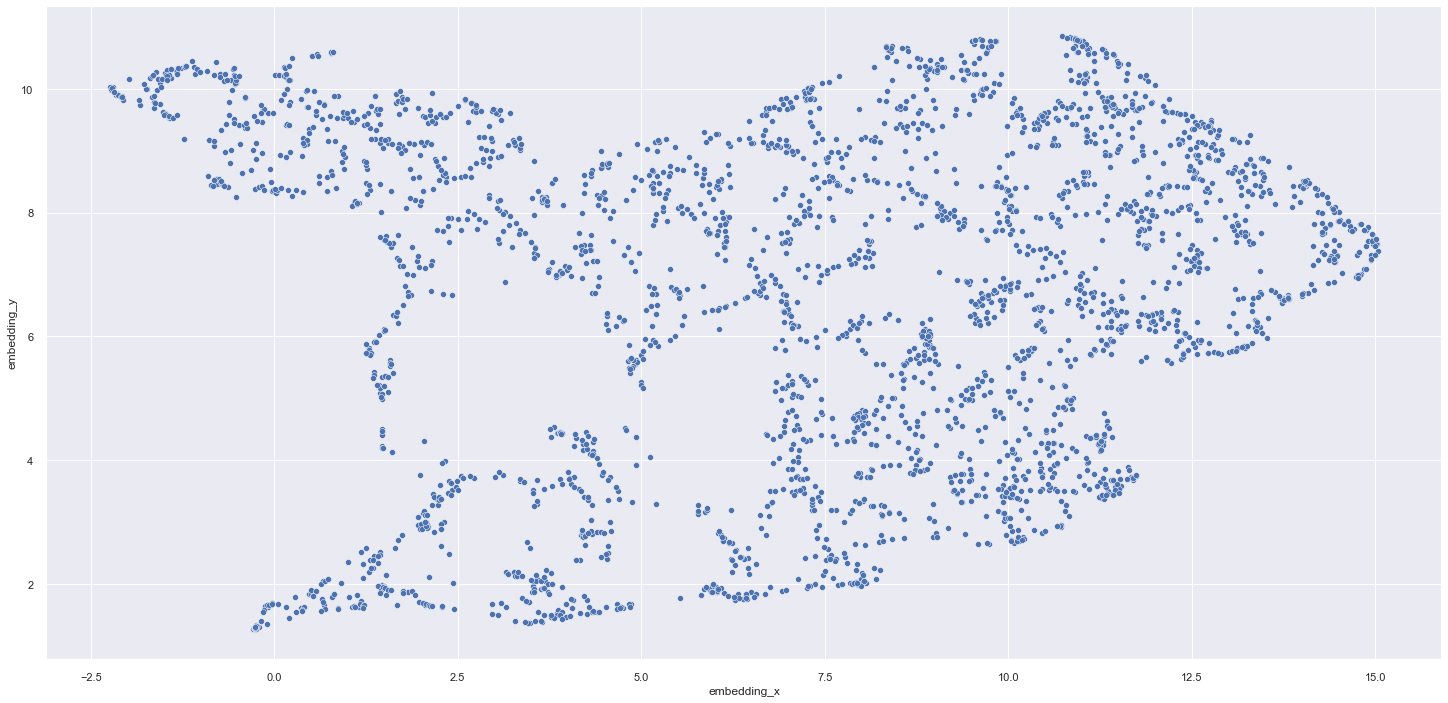

In [216]:
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( x )

# Embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]


# Plot UMAP
sns.scatterplot( x='embedding_x',
                 y='embedding_y',
                 data = df_pca )

### 4.3.3 T-SNE

/Users/adriele/opt/anaconda3/envs/env_pa005/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/adriele/opt/anaconda3/envs/env_pa005/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

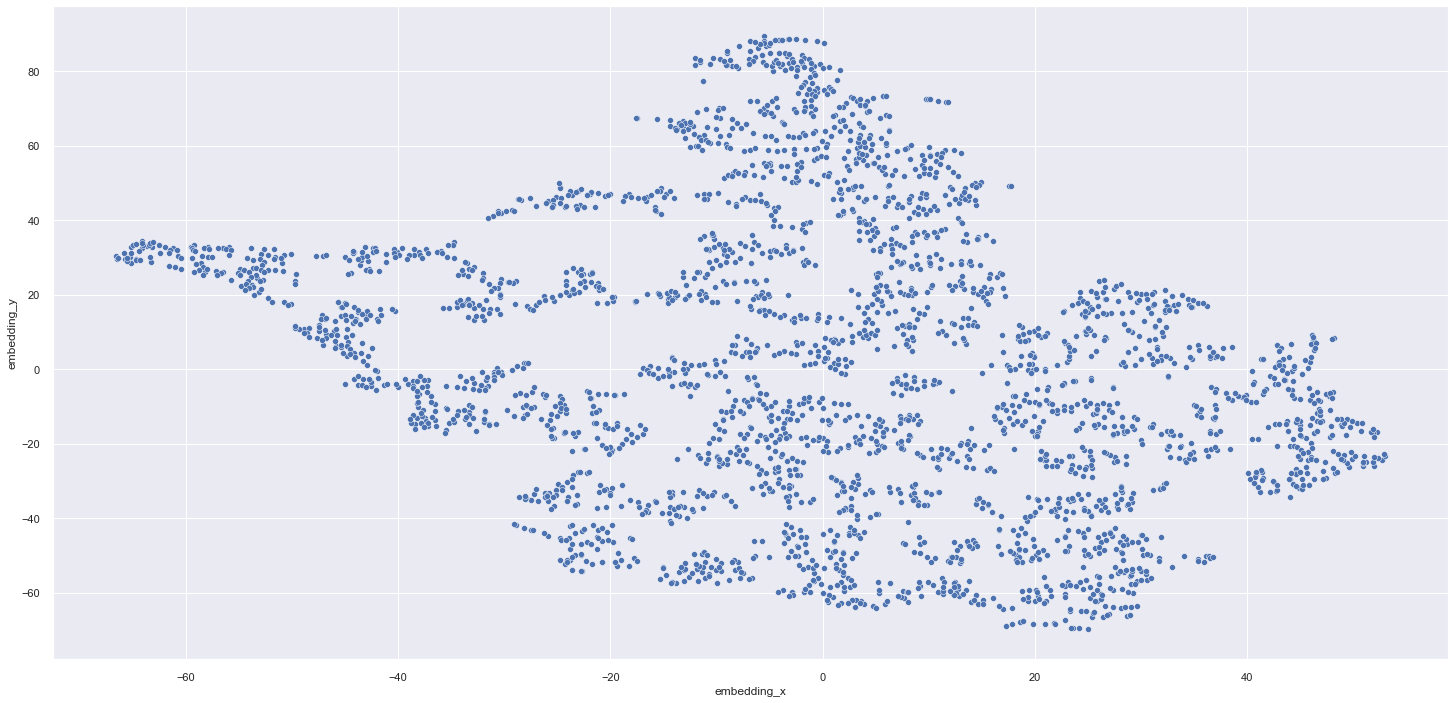

In [220]:
reducer = mn.TSNE( n_components=2, random_state=42, n_jobs =1)

embedding = reducer.fit_transform( x )

# Embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]


# Plot UMAP
sns.scatterplot( x='embedding_x',
                 y='embedding_y',
                 data = df_pca )

### 4.3.4 Tree Based Embeding

In [225]:
x = df4.drop( columns=[ 'customer_id', 'gross_revenue'], axis=1)
y = df4['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor( n_estimators=100, random_state=42 )

# Model training
rf_model.fit( x, y )



# dataframe Leaf
df_leaf= pd.DataFrame( rf_model.apply( x ) )

RandomForestRegressor(random_state=42)

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

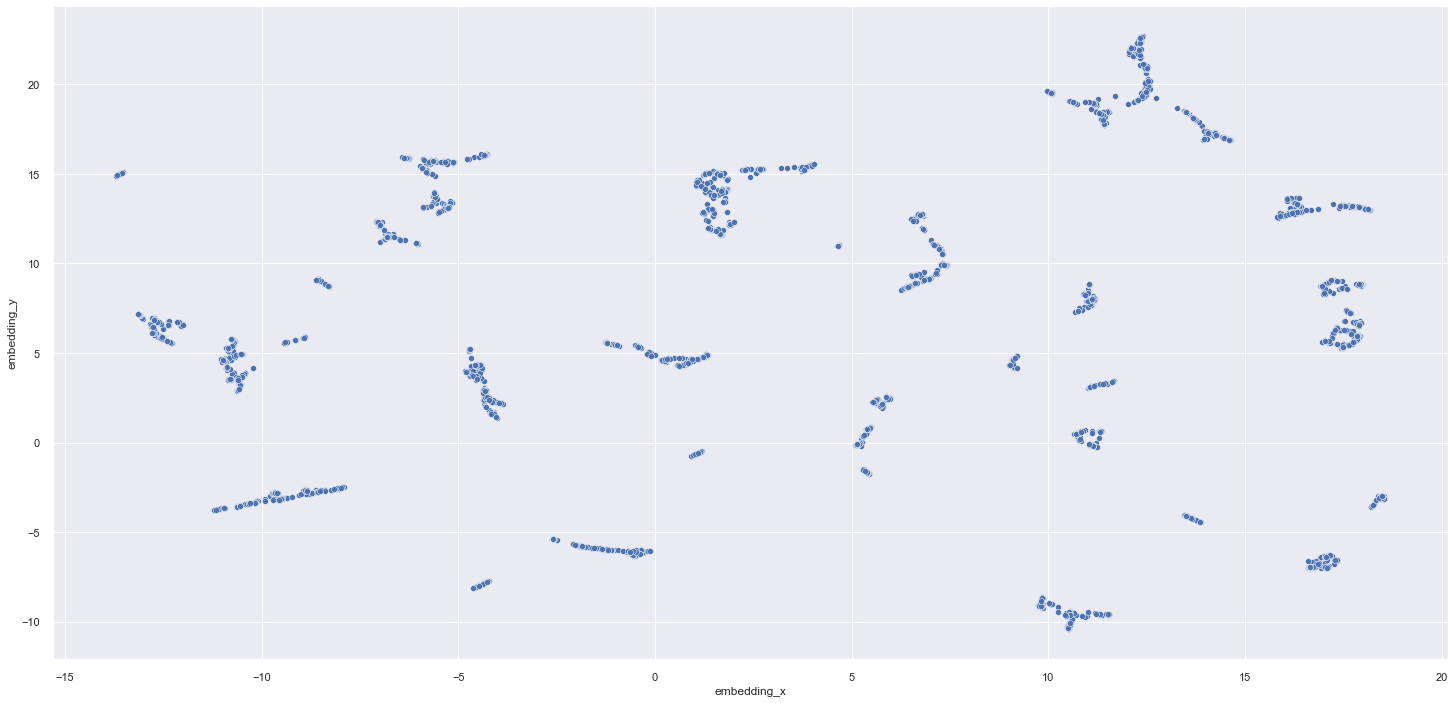

In [227]:
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( df_leaf )

# Embedding
df_leaf['embedding_x'] = embedding[:, 0]
df_leaf['embedding_y'] = embedding[:, 1]


# Plot UMAP
sns.scatterplot( x='embedding_x',
                 y='embedding_y',
                 data = df_leaf )

# <font color= 'red'> 5.0 Data Preparation

In [299]:
df5 = df4.copy()

In [300]:
mm = pp.MinMaxScaler()

df5[ 'gross_revenue' ]    = mm.fit_transform( df5[[ 'gross_revenue' ]] )
df5[ 'recency_days' ]     = mm.fit_transform( df5[[ 'recency_days' ]] )
df5[ 'qtde_invoices' ]    = mm.fit_transform( df5[[ 'qtde_invoices' ]] )
df5[ 'qtde_itens' ]       = mm.fit_transform( df5[[ 'qtde_itens' ]] )
df5[ 'qtde_products' ]    = mm.fit_transform( df5[[ 'qtde_products' ]] )
df5[ 'avg_ticket' ]       = mm.fit_transform( df5[[ 'avg_ticket' ]] )
df5[ 'avg_recency_days' ] = mm.fit_transform( df5[[ 'avg_recency_days' ]] )
df5[ 'frequency' ]        = mm.fit_transform( df5[[ 'frequency' ]] )
df5[ 'qtde_returns' ]     = mm.fit_transform( df5[[ 'qtde_returns' ]] )
df5[ 'avg_basket_size' ]  = mm.fit_transform( df5[[ 'avg_basket_size' ]] )

df5[ 'avg_unique_basket_size' ] = mm.fit_transform( df43[[ 'avg_unique_basket_size' ]] )

# <font color= 'red'> 6.0 Feature Selection

In [304]:
df6 = df5.copy()

# <font color= 'red'> 7.0 Fine Tunning Hyperparameter

In [312]:
x = df6.drop( columns=['customer_id'] )

clusters = [2, 3, 4, 5, 6, 7]

## 7.1 K-Means

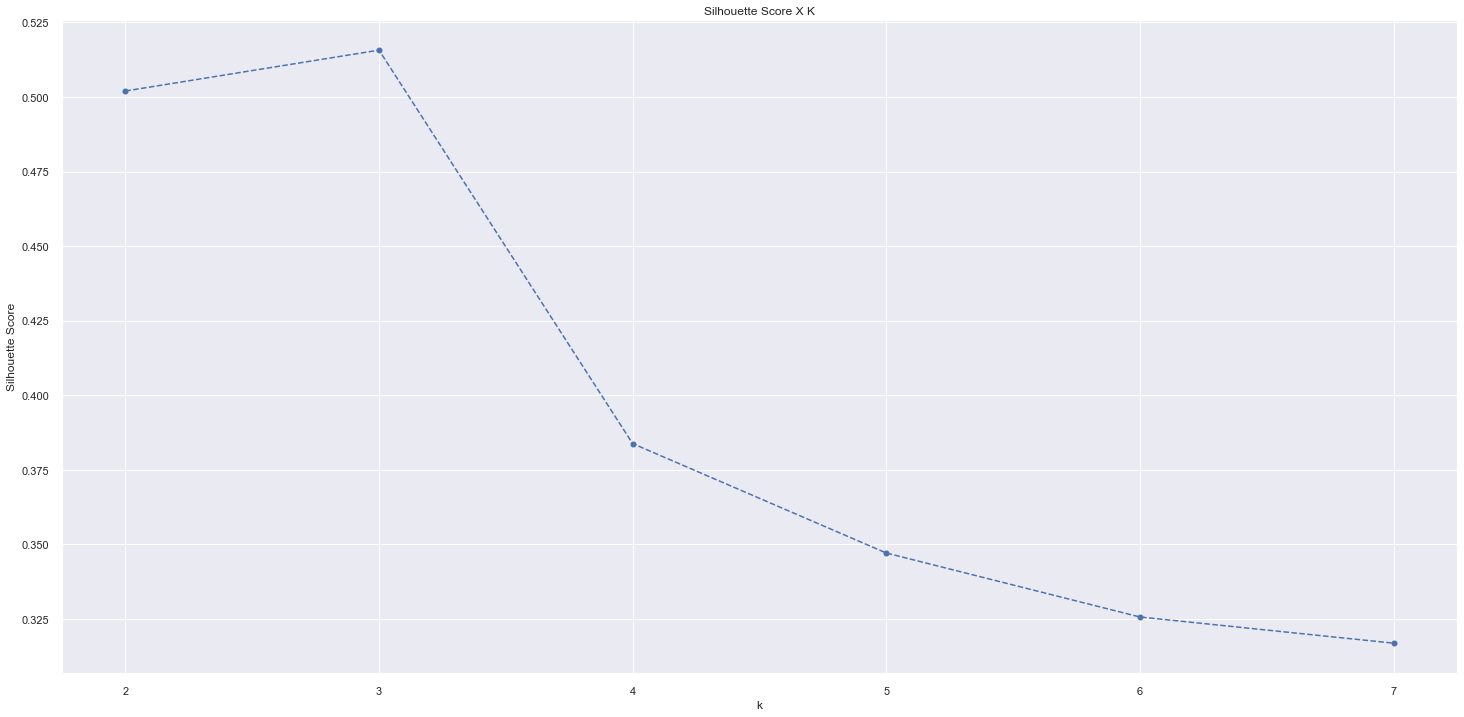

In [346]:
kmeans_list = []
for k in clusters:
    # Model definition
    kmeans_model = c.KMeans( n_clusters=k )

    # Model training
    kmeans_model.fit( x )

    # Model  predict
    labels = kmeans_model.predict( x )

    # Model performance
    sil = m.silhouette_score( x, labels, metric='euclidean')
    kmeans_list.append( sil )
    
    
    
plt.plot( clusters, kmeans_list, linestyle='--', marker='o', color='b')  
plt.xlabel( 'k');
plt.ylabel( 'Silhouette Score' );
plt.title( 'Silhouette Score X K');

## 7.2 GMM

AIC - Data ajustment
BIC - Parameters ajustment

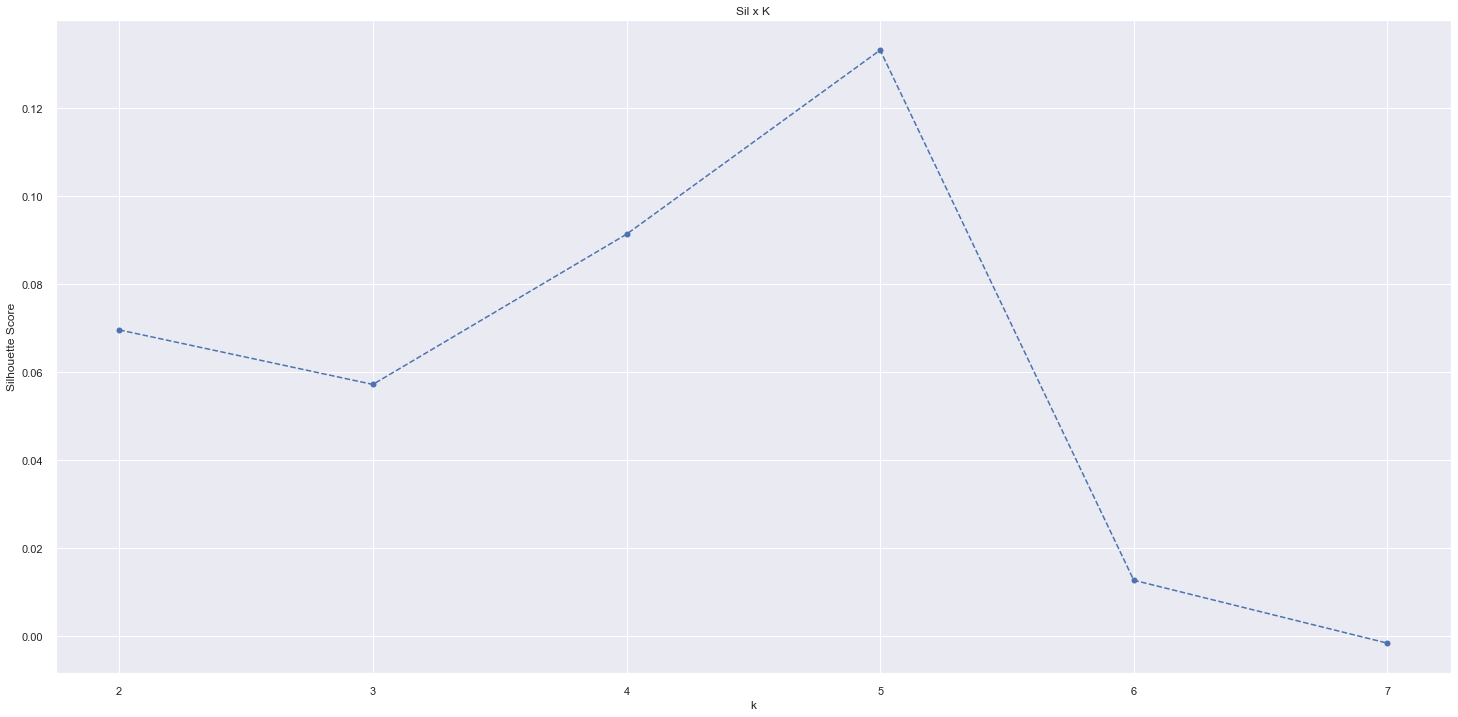

In [352]:
gmm_list = []
for k in clusters:
    # Model definition
    gmm_model = mx.GaussianMixture( n_components=k )

    # Model training
    gmm_model.fit( x )

    # Model  predict
    labels = gmm_model.predict( x )

    # Model performance
    sil = m.silhouette_score( x, labels, metric='euclidean')
    gmm_list.append( sil )
    
    
    
plt.plot( clusters, gmm_list, linestyle='--', marker='o', color='b')  
plt.xlabel( 'k');
plt.ylabel( 'Silhouette Score' );
plt.title( 'Sil x K');

## 7.3 Hierarchical Clustering

[]

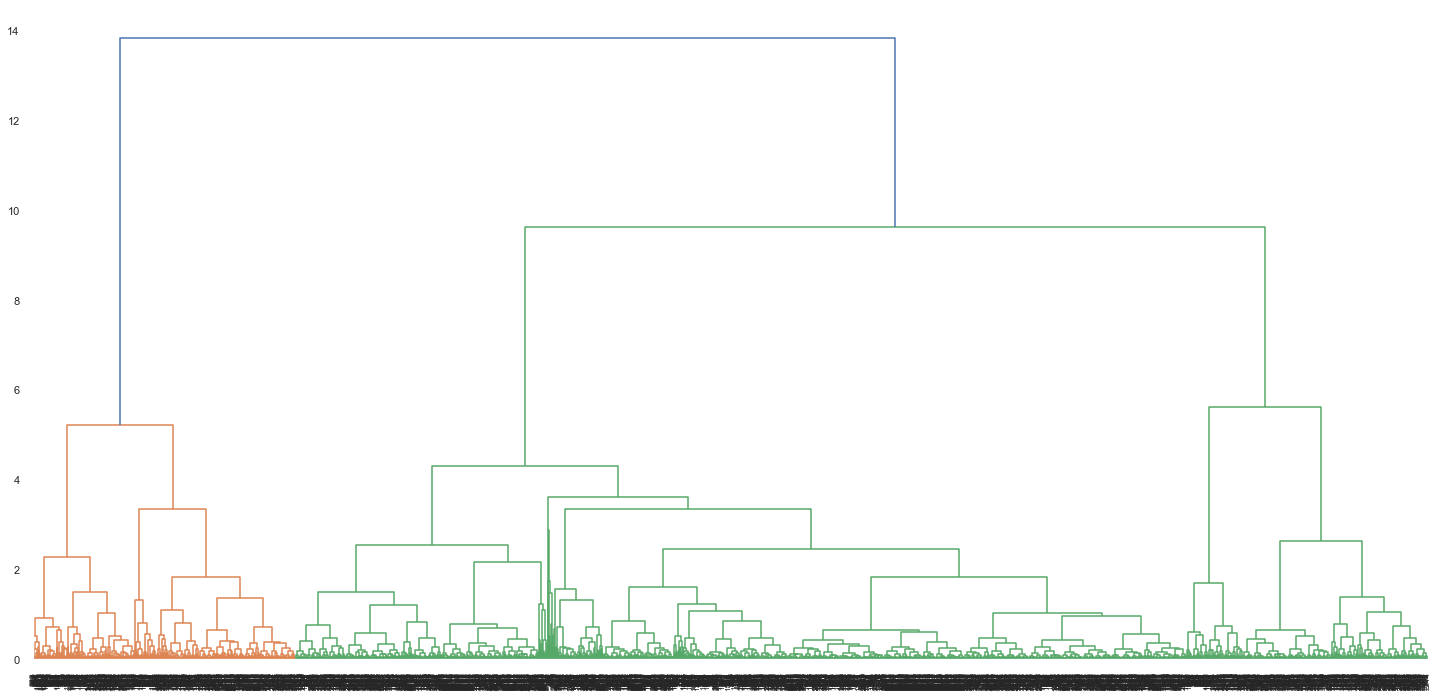

In [364]:

# Model definition and training
hc_model =hc.linkage( x, 'ward' )
hc.dendrogram(
    hc_model,
    leaf_rotation=90,
    leaf_font_size=8
)

plt.plot()

<function matplotlib.pyplot.show(close=None, block=None)>

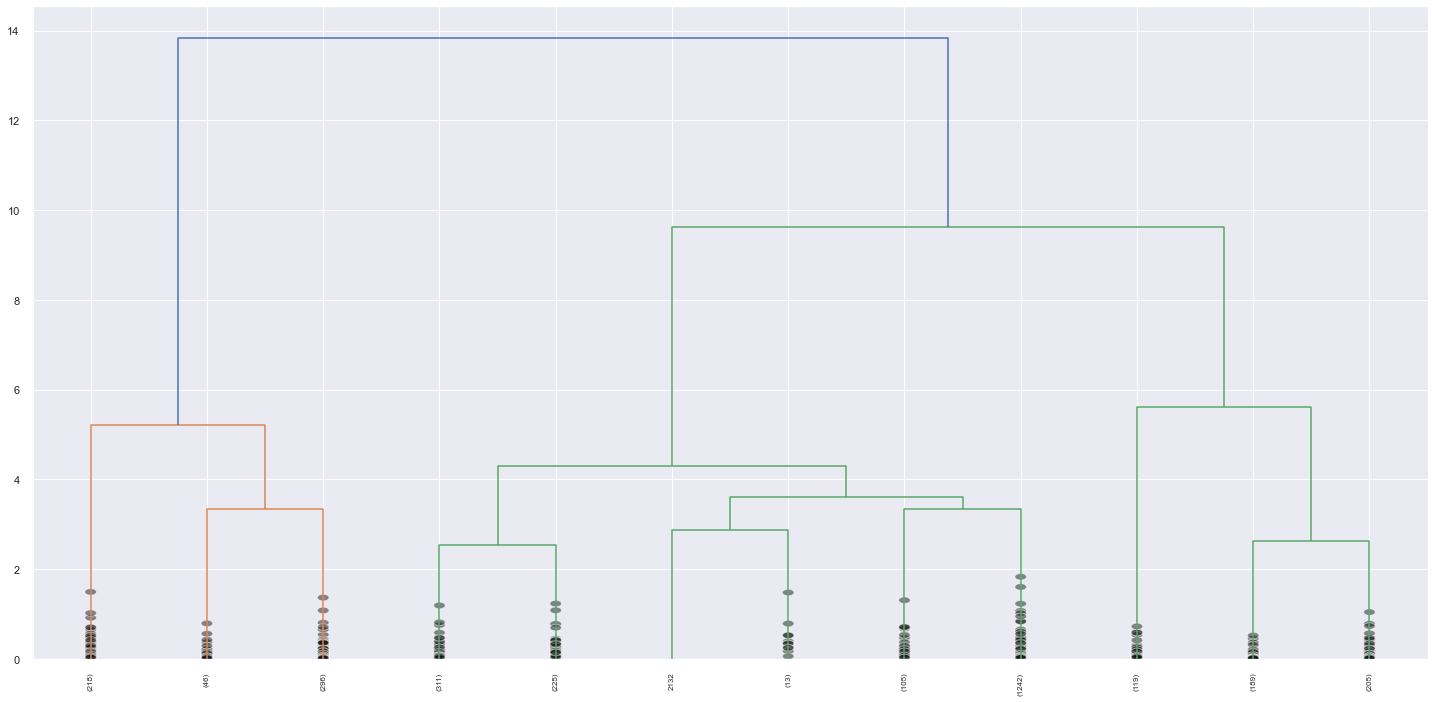

In [365]:
hc.dendrogram(
    hc_model,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90,
    leaf_font_size=8,
    show_contracted=True
)

plt.show

### 7.3.1. HClustering Silhouette Score

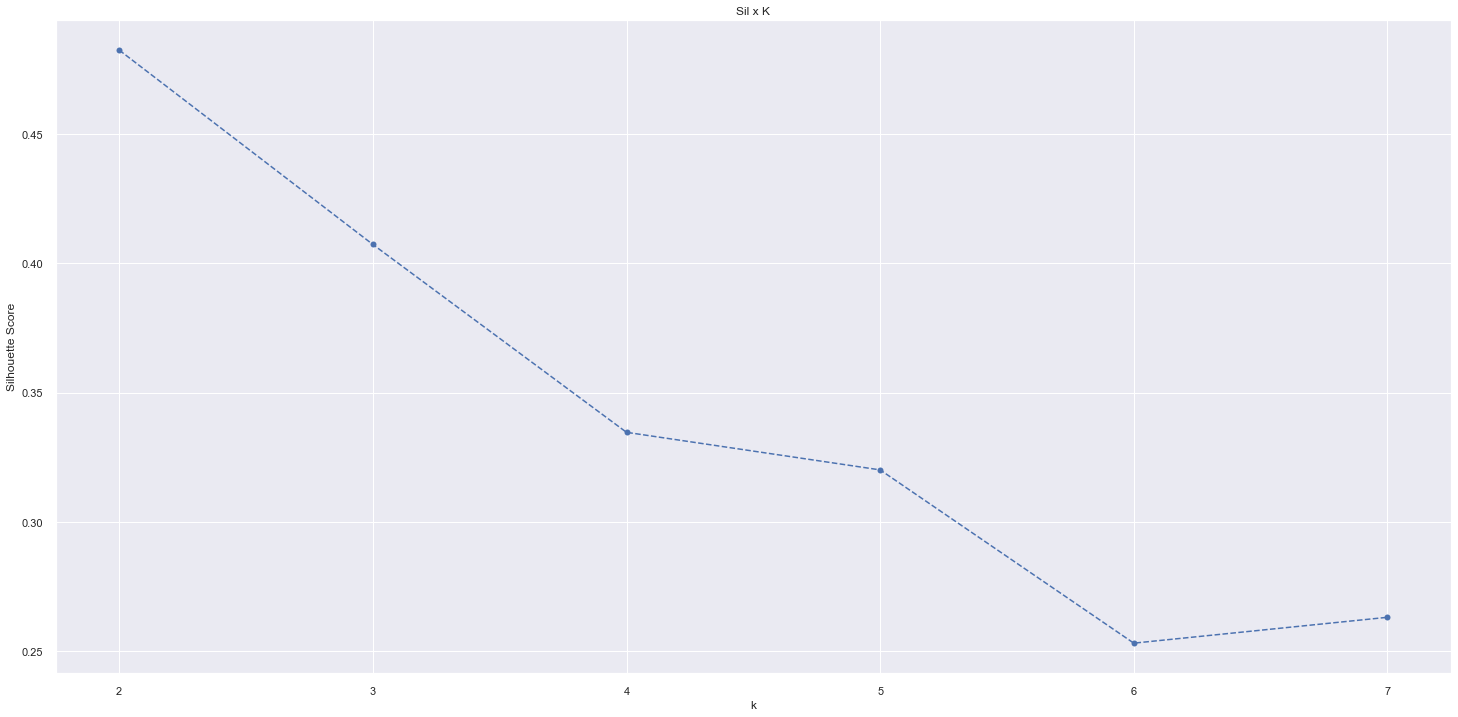

In [368]:
hc_list = []
for k in clusters:
    # Model definition
    hc_model =hc.linkage( x, 'ward' )

    # Model  predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # Model performance
    sil = m.silhouette_score( x, labels, metric='euclidean')
    hc_list.append( sil )
    
    
    
plt.plot( clusters, hc_list, linestyle='--', marker='o', color='b')  
plt.xlabel( 'k');
plt.ylabel( 'Silhouette Score' );
plt.title( 'Sil x K');

## 7.4 DBSCAN

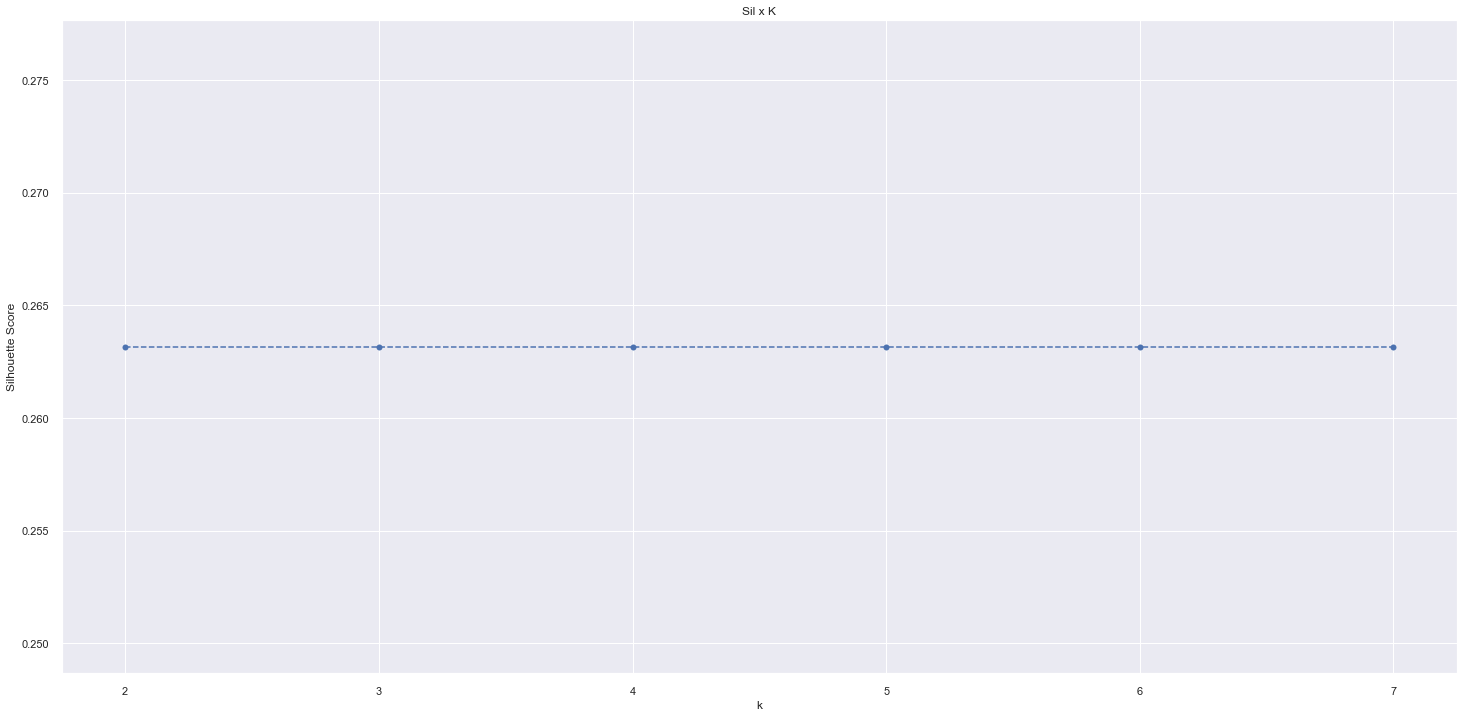

In [373]:
dbscan_list = []
eps =0.1
min_samples = 20

for k in clusters:
    # Model definition
    dbscan_model =c.DBSCAN( eps=eps, min_samples=min_samples )
    
    # Model training
    dbscan_model.fit( x )

    # Model  predict
    #labels = hc.fcluster( dbscan_model, k, criterion='maxclust' )

    # Model performance
    sil = m.silhouette_score( x, labels, metric='euclidean')
    dbscan_list.append( sil )
    
    
    
plt.plot( clusters, dbscan_list, linestyle='--', marker='o', color='b')  
plt.xlabel( 'k');
plt.ylabel( 'Silhouette Score' );
plt.title( 'Sil x K');

## 7.5 Results

In [ ]:
# Model Name k=2 | k=3 | k=4 | k=5 ..
# KMeans      ss   ss    ss    ss
# GMM         ss   ss    ss    ss
# HC          ss   ss    ss    ss
# DBSCAN      ss   ss    ss    ss

In [369]:
df_results = pd.DataFrame({'KMeans': kmeans_list,
                           'GMM' :gmm_list,
                           'HC' : hc_list }
                         
                         ).T

df_results.columns = clusters
df_results.style.highlight_max( color='lightgreen', axis=1)


,2,3,4,5,6,7
KMeans,0.502031,0.515733,0.383828,0.347149,0.325700,0.316927
GMM,0.069575,0.057181,0.091315,0.133154,0.012687,-0.001611
HC,0.482447,0.407311,0.334682,0.320155,0.253170,0.263165


In [338]:
# wss =[]
# for k in clusters:
#     # modeldefinition
#     kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42 )
    
#     # model training
#     kmeans.fit( x )
    
#     # model validation
#     wss.append( kmeans.inertia_ )
    
# # plot wss
# plt.plot( clusters, wss, linestyle='--', marker='o', color='b' )
# plt.xlabel( 'K' )
# plt.ylabel( 'Within Cluster Sum od Square' );
# plt.title( 'WSS vs K');
  

## 7.2 Silhouette Score

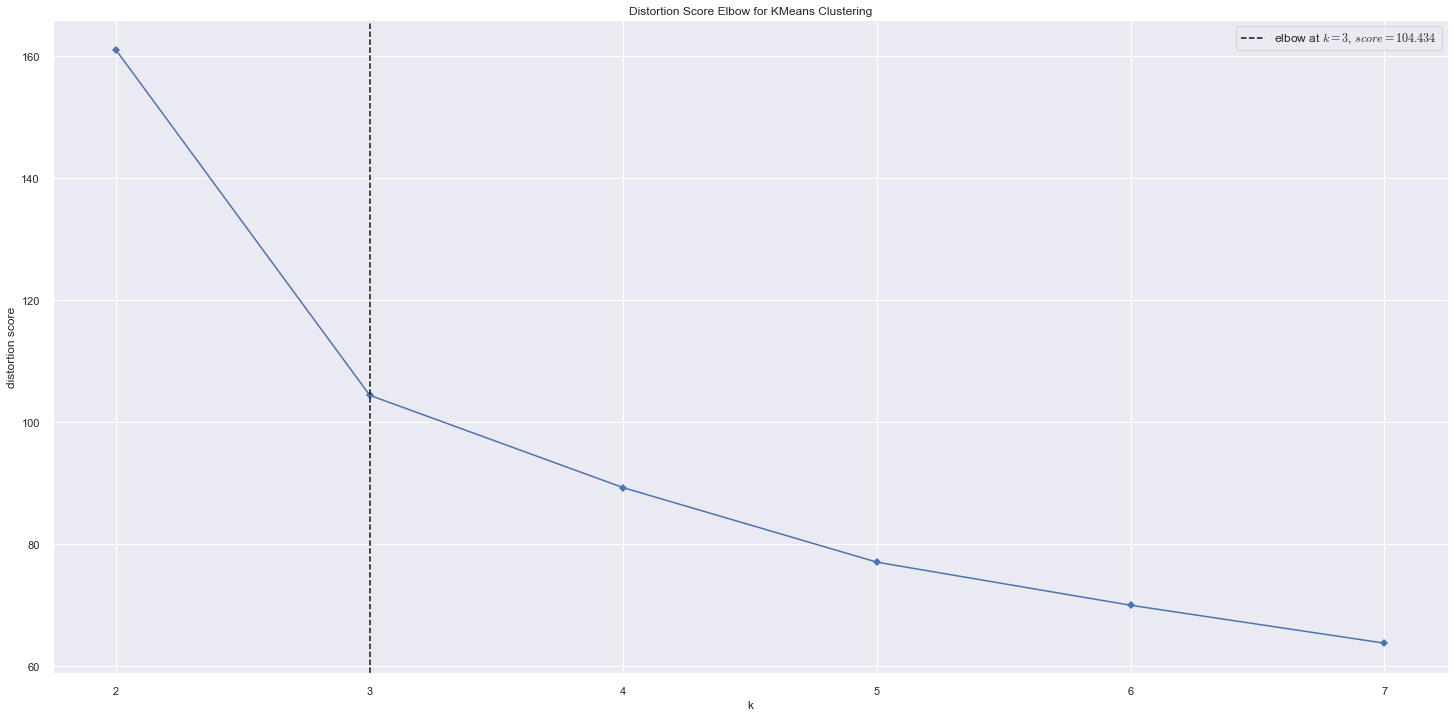

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [315]:
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, timings=False )
kmeans.fit( x )
kmeans.show()

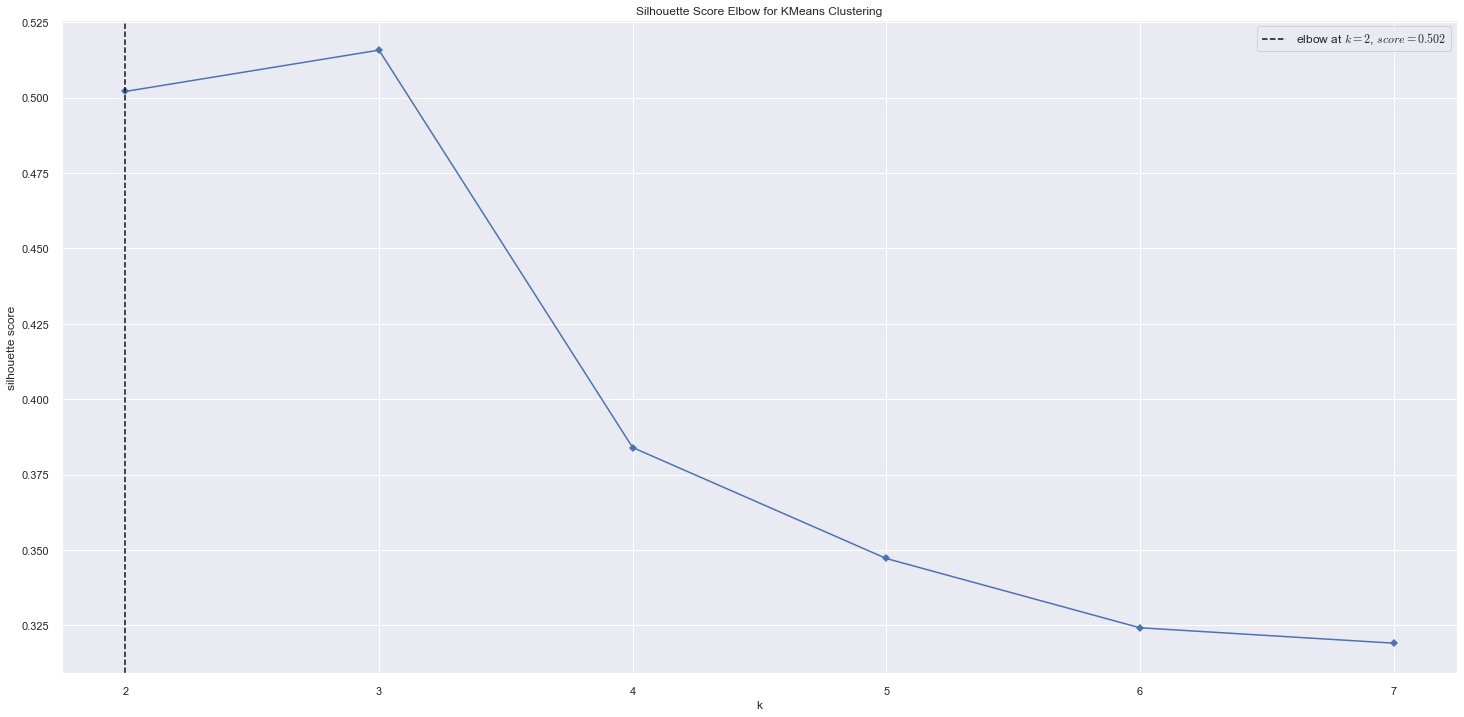

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [316]:
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, metric='silhouette', timings=False )
kmeans.fit( x )
kmeans.show()

## 7.3 Silhouette Analysis

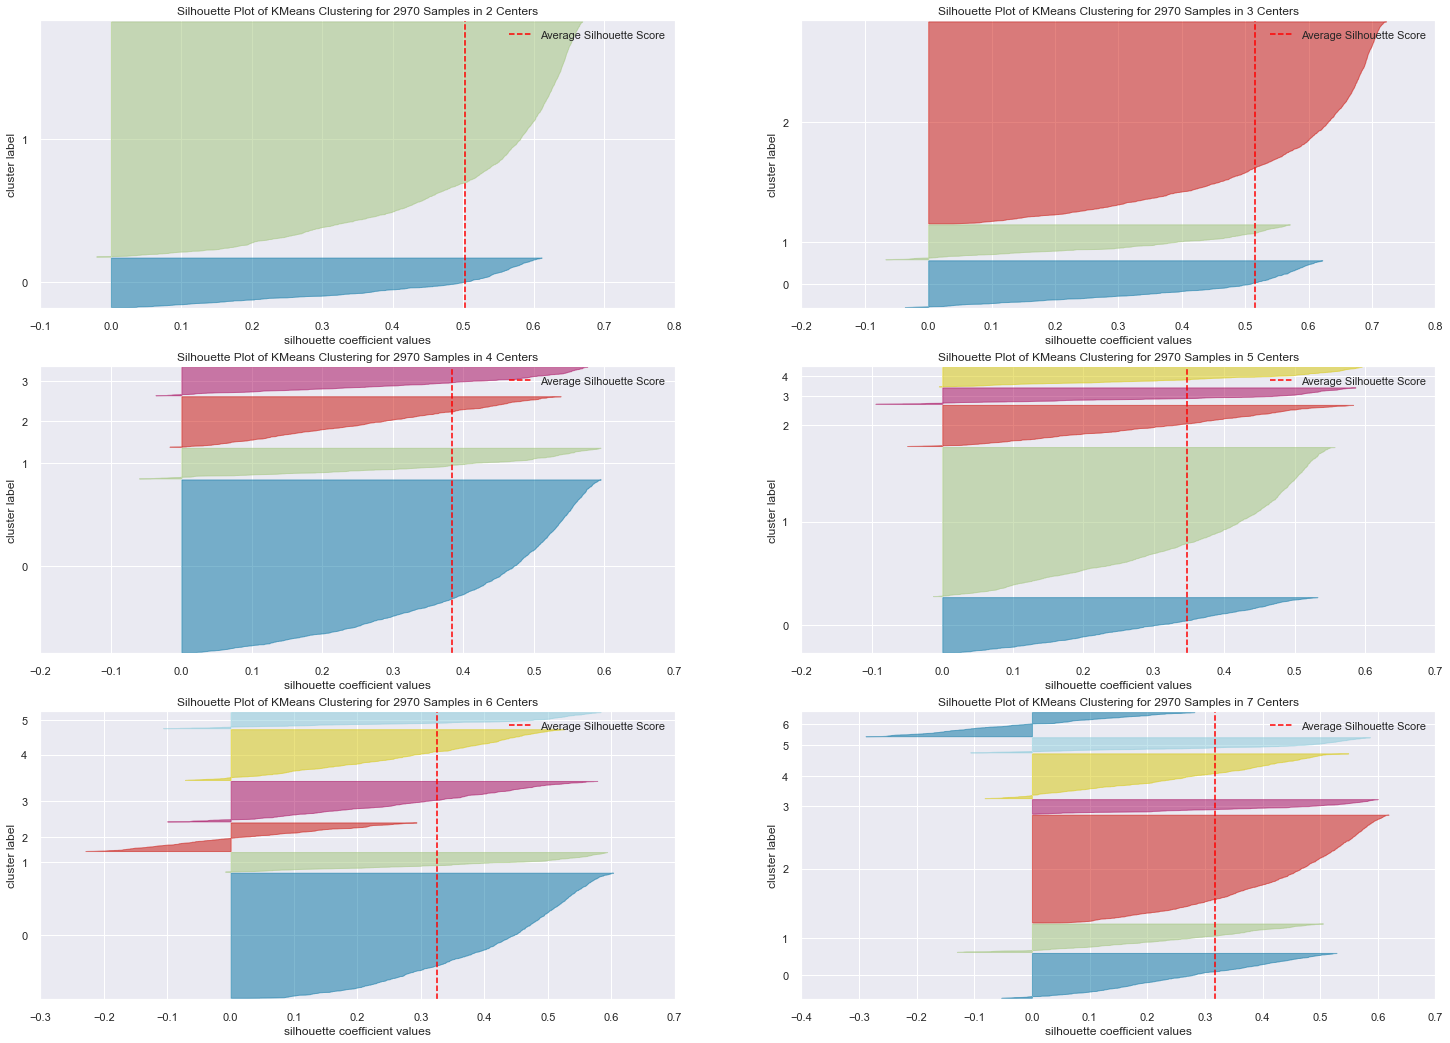

In [317]:
fig, ax = plt.subplots( 3, 2, figsize=(25, 18 ) )
#k = [2, 3, 4, 5, 6, 7]


for k in clusters:    
    km = c.KMeans( n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42 )
    q, mod = divmod( k, 2 )
    
    visualizer = SilhouetteVisualizer( km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit( x )
    visualizer.finalize()

# <font color= 'red'> 8.0 Model Training

In [318]:
df8 = df6.copy()

## 8.1 K- Means

In [319]:
#Model definition
k = 3
kmeans =c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300 )

# Model training
kmeans.fit( x )

# Clustering
labels = kmeans.labels_

## 8.2 Cluster Validation

In [320]:
# WSS (Within cluster sum of square)
print( 'WSS value: {}'.format( kmeans.inertia_ ) )

# SS ( Silhouette score )
print( 'SS value: {}'.format( m.silhouette_score( x, labels, metric='euclidean' ) ) )

WSS value: 104.43392679652325
SS value: 0.5157334061217155


# <font color= 'red'> 9.0 Cluster Analysis

In [333]:
df9 = df8.copy()
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_itens,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size,cluster
0,17850,0.019292,0.997319,0.160976,0.000420,0.011204,0.000444,0.094521,0.081323,0.000494,0.001234,0.025896,1
1,13047,0.011559,0.150134,0.039024,0.001605,0.058263,0.000367,0.071918,0.007251,0.000432,0.003789,0.060260,2
2,12583,0.024000,0.005362,0.068293,0.019347,0.063305,0.000593,0.060788,0.006732,0.000617,0.008252,0.048431,2
3,13748,0.003375,0.254692,0.019512,0.002074,0.012885,0.000532,0.251142,0.002089,0.000000,0.002143,0.015400,2
4,15100,0.003116,0.892761,0.009756,0.000580,0.000000,0.004639,0.020822,0.022365,0.000272,0.000634,0.000000,1


## 9.1 Visualization Inpection

/Users/adriele/opt/anaconda3/envs/env_pa005/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


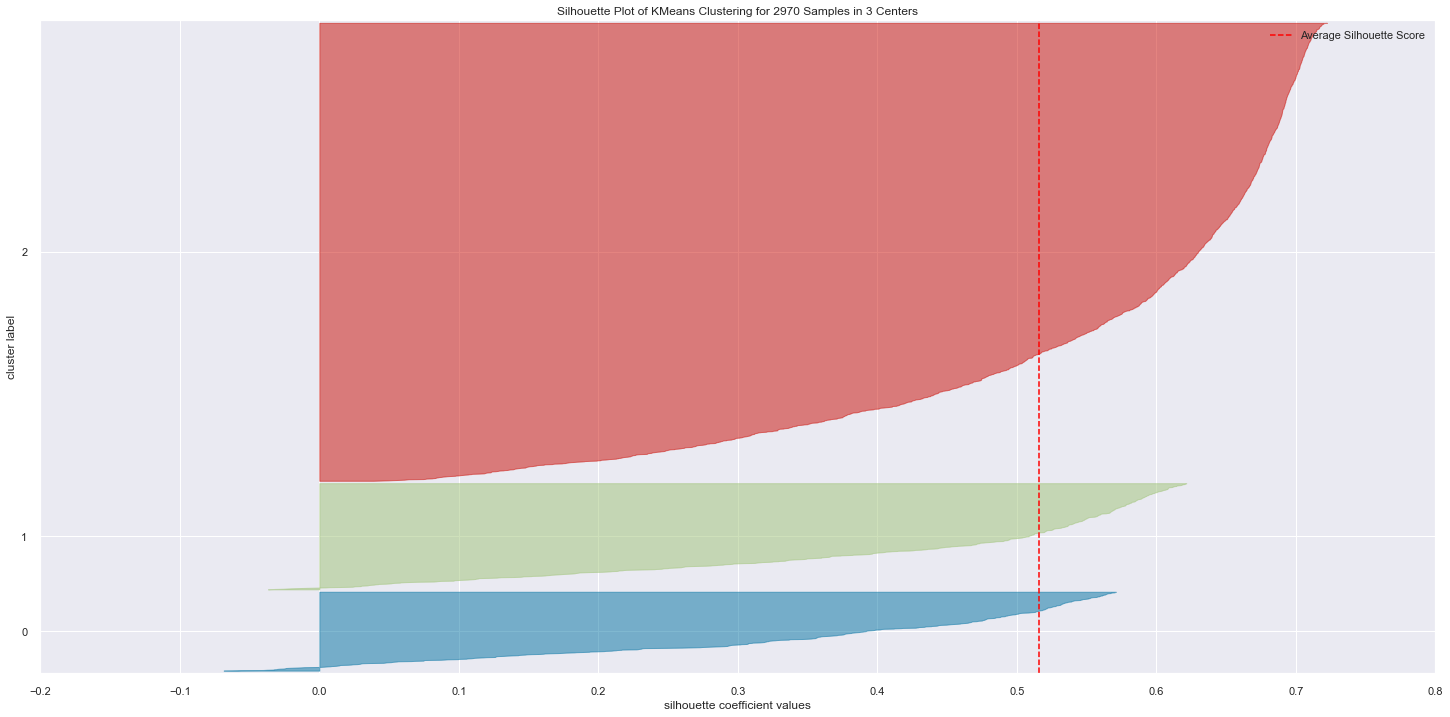

In [334]:
visualizer = SilhouetteVisualizer( kmeans, colors='yellowbrick' )
visualizer.fit ( x )
visualizer.finalize()

# fig = px.scatter_3d( df9, x='recency_days', y='invoice_no', z='gross_revenue', color='cluster' )
# fig.show()

## 9.2 2D Plot

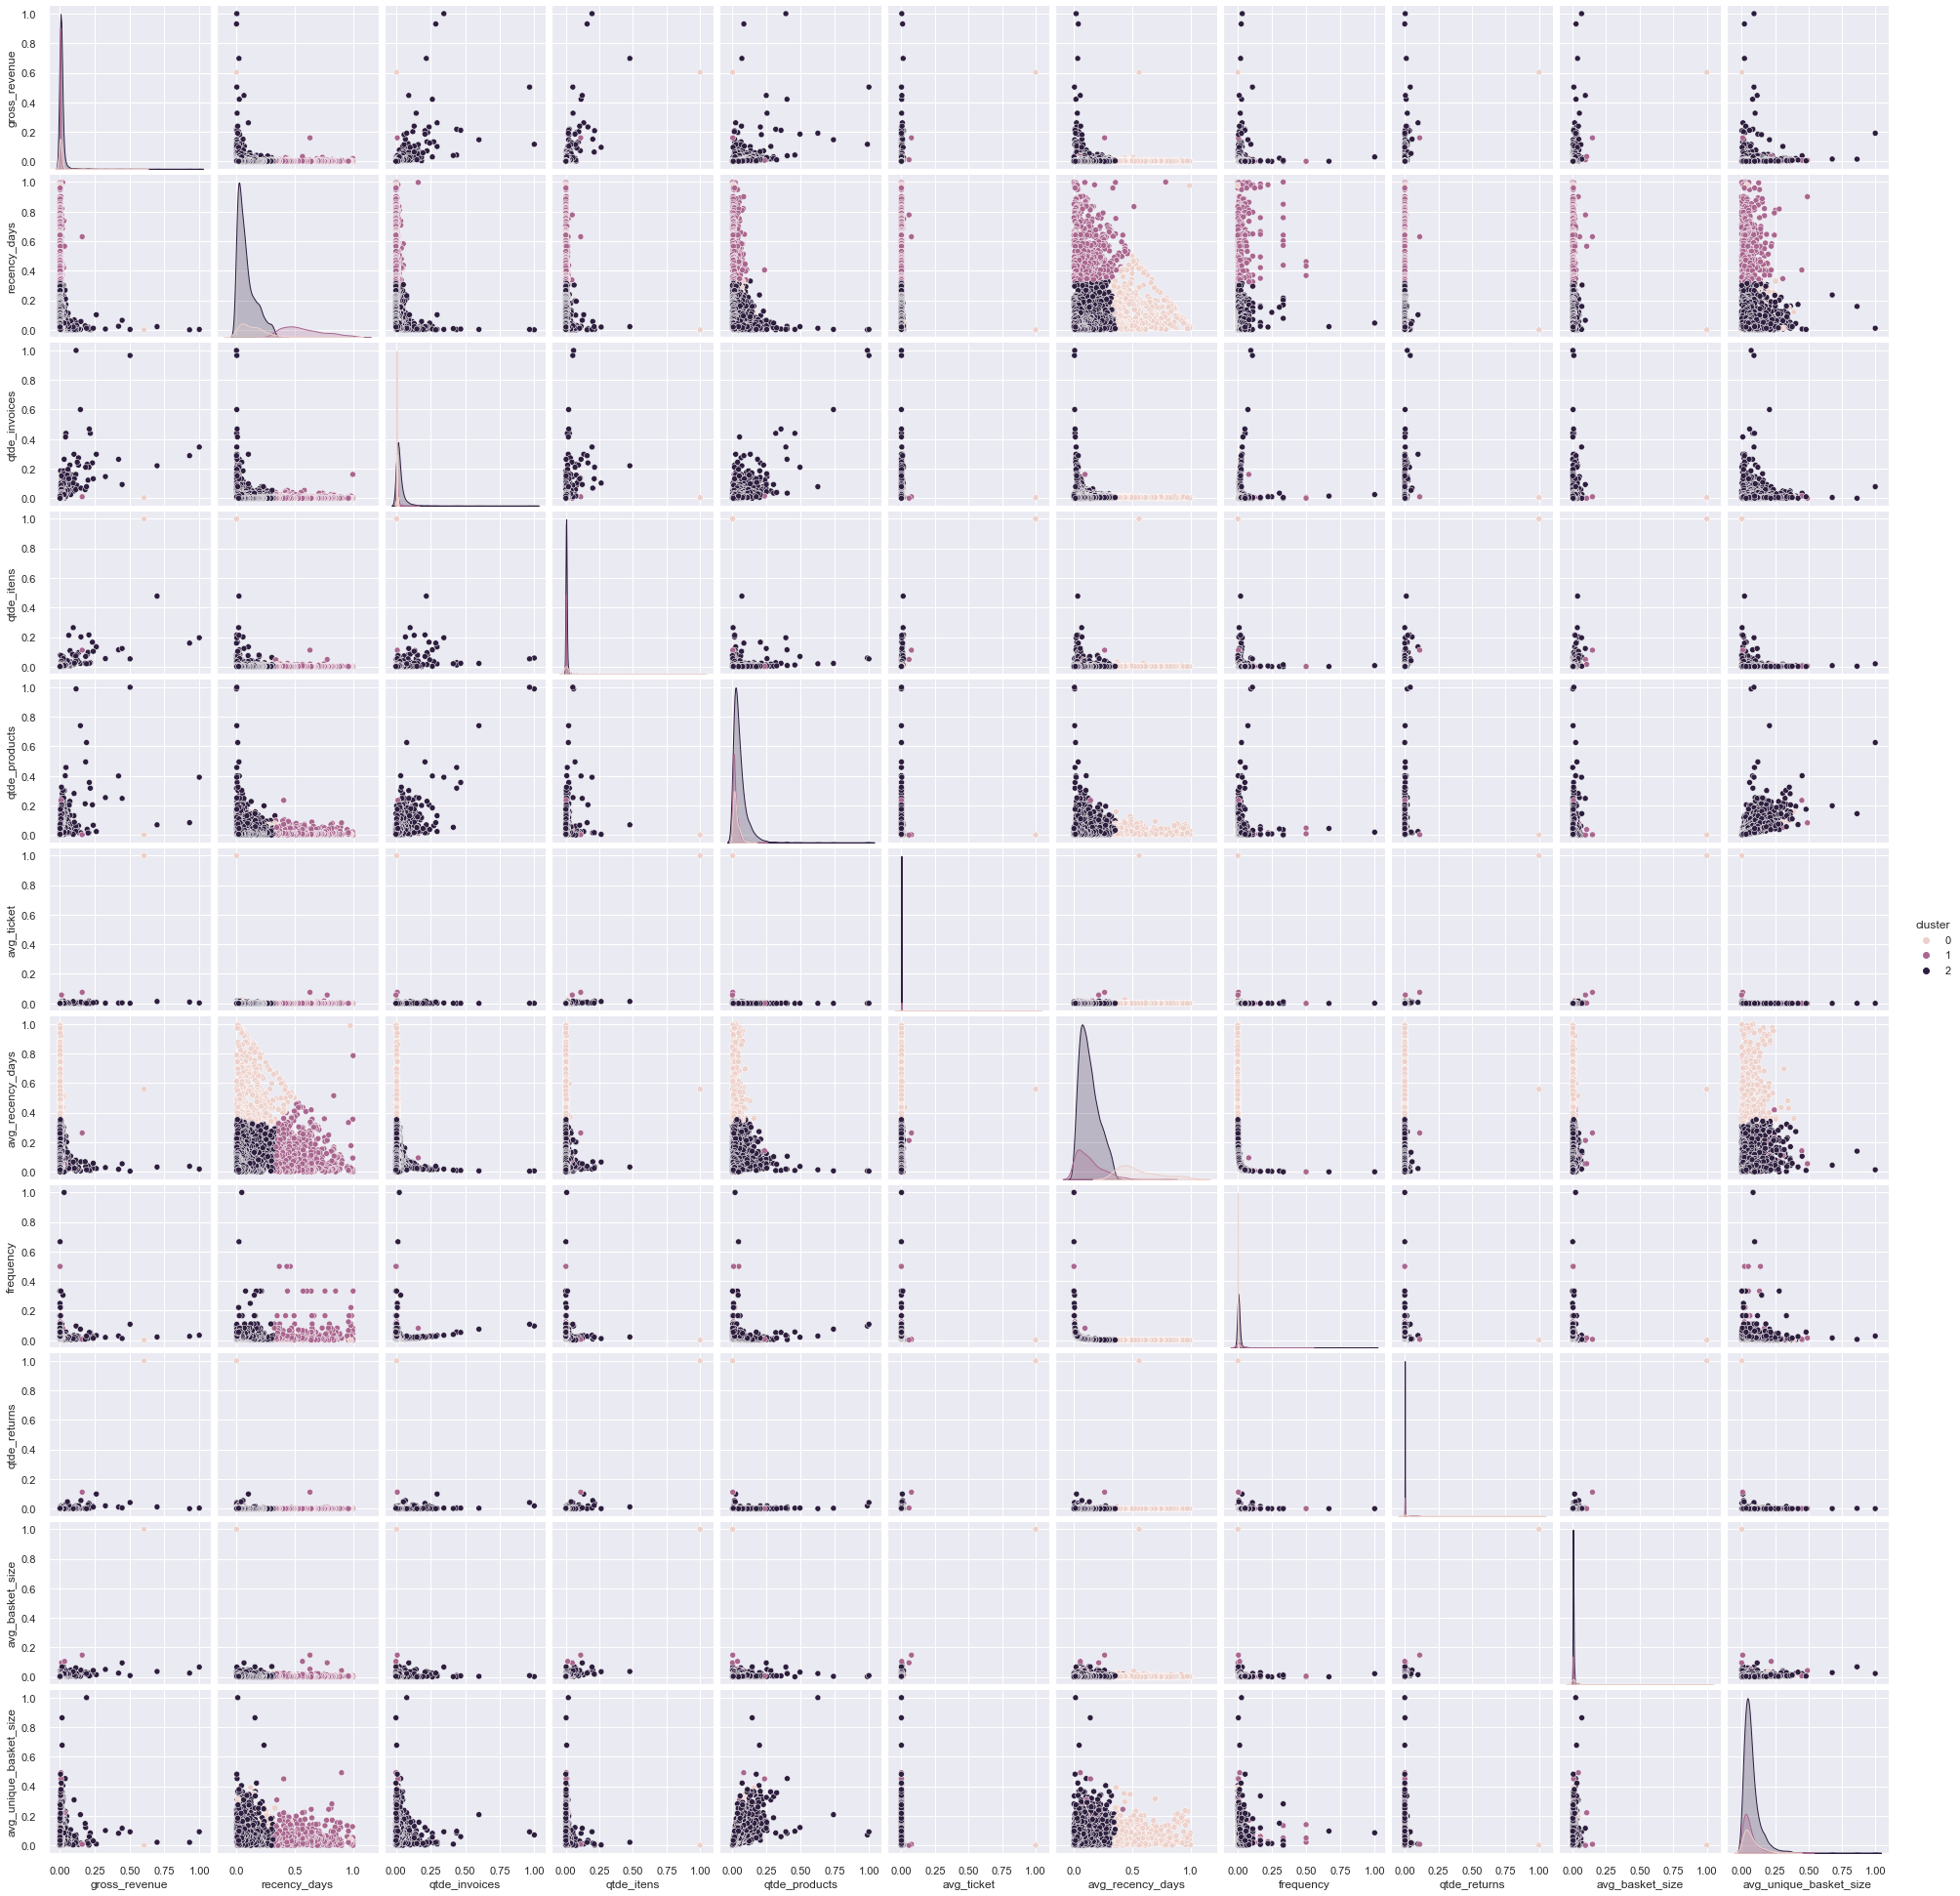

In [335]:
df_viz = df9.drop( columns='customer_id', axis=1 )
sns.pairplot( df_viz, hue='cluster')

## 9.3 UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

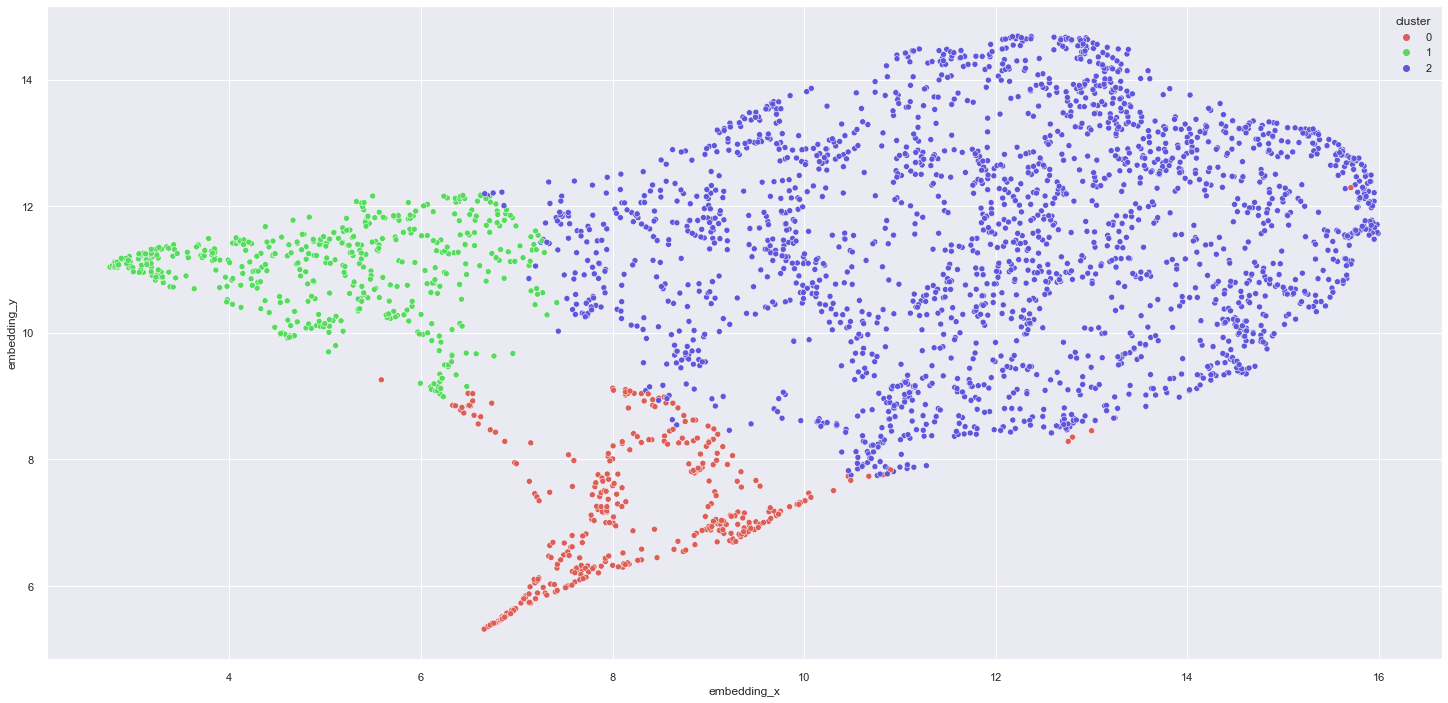

In [336]:
reducer = umap.UMAP( n_neighbors=90, random_state=42 )
embedding = reducer.fit_transform( x )

# Embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]


# Plot UMAP
sns.scatterplot( x='embedding_x', y='embedding_y',
               hue='cluster',
               palette = sns.color_palette( 'hls', n_colors=len( df_viz['cluster'].unique() ) ),
               data = df_viz )

## 9.4 Cluster Profile

In [337]:
# Number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross Revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )

# Agv recency days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster' )

# Avg invoice no
df_avg_invoice_no = df9[['avg_ticket', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_invoice_no, how='inner', on='cluster' )

df_cluster.head()

,cluster,customer_id,perc_customer,gross_revenue,recency_days,avg_ticket
0,0,365,12.289562,0.004269,0.142745,0.003252
1,1,491,16.531987,0.003271,0.573099,0.000879
2,2,2114,71.178451,0.012307,0.084485,0.000544


## Cluster 01:  ( Insider Candidate )

  - Number of Customer = 4,335 ( 99% of customer )
  - Averange Recency   = 92 days;
  - Averange Purchase  = 5 purchase
  - Averang  Revenue   =  $ 1.372,57 dolars
  
# Cluster 02:

  - Number of Customer = 31 ( 71% of customer )
  - Averange Recency   = 13 days;
  - Averange Purchase  = 53 purchase
  - Averang  Revenue   =  $ 40,543,51 dolars  
  
# Cluster 03:

  - Number of Customer = 4 ( 14% of customer )
  - Averange Recency   = 7 days;
  - Averange Purchase  = 89 purchase
  - Averang  Revenue   =  $ 182,181.98 dolars    

# <font color= 'red'> 10.0 Deploy to production